In [50]:
# Required imports for this section (ensure they are imported at the top of your script)
import pandas as pd
import numpy as np
import folium
import branca # Needed for custom Folium legends
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from scipy.special import expit  # Numerically stable sigmoid function
import statsmodels.api as sm


num_quantiles = 10  # Number of quantiles for centrality
year = 2017


df = pd.read_csv('../data/processed/cost_data.csv')
df = df[df['Year'] == year]
df = df.reset_index(drop=True)

simulated_yard_data = pd.read_parquet('../data/processed/simulations/yard_data_apr3.parquet')
simulated_yard_data = simulated_yard_data[simulated_yard_data['Year'] == year]
simulated_yard_data = simulated_yard_data.reset_index(drop=True)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI1'] = np.where(simulated_yard_data['Variety'].isin(['nugget', 'mosaic']), 1, 0)
simulated_yard_data['tI1'] = simulated_yard_data['tI1'].astype(np.int32)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI2'] = np.where(simulated_yard_data['Variety'].isin(['chinook', 'simcoe']), 1, 0)
simulated_yard_data['tI2'] = simulated_yard_data['tI2'].astype(np.int32)

tI1 = simulated_yard_data['tI1'].values.reshape(-1, 1)
tI2 = simulated_yard_data['tI2'].values.reshape(-1, 1)

# Filter the DataFrame to include only the relevant columns
real_yard_data = df[['Field ID', 'Year', 'Centroid Lat', 'Centroid Long', 'Grower', 'Variety', 'Initial Strain']].copy()

period = ['may-jun', 'jun-jul']

# Import data
if year == 2014:
    X = np.load('../data/processed/data_2014.npz')

elif year == 2015:
    X = np.load('../data/processed/data_2015.npz')

elif year == 2016:
    X = np.load('../data/processed/data_2016.npz')

elif year == 2017:
    X = np.load('../data/processed/data_2017.npz')

N = int(X['N'])

distance = X['distance']
dist = X['distance']
# tI1 = X['tI1'].reshape(N,1)
# tI2 = X['tI2'].reshape(N,1)
sI2 = X['sI2'].reshape(N,1)

y_apr = X['y_apr'].reshape(N,1)
y_may = X['y_may'].reshape(N,1)
y_jun = X['y_jun'].reshape(N,1)
y_jul = X['y_jul'].reshape(N,1)

n_apr = X['n_apr'].reshape(N,1)
n_may = X['n_may'].reshape(N,1)
n_jun = X['n_jun'].reshape(N,1)
n_jul = X['n_jul'].reshape(N,1)

area_apr = X['a_apr'].reshape(N,1)
a_apr = X['a_apr'].reshape(N,1)
a_may = X['a_may'].reshape(N,1)
a_jun = X['a_jun'].reshape(N,1)
a_jul = X['a_jul'].reshape(N,1)

w_apr = X['wind_apr']
w_may = X['wind_may']
w_jun = X['wind_jun']
w_jul = X['wind_jul']

sI1_apr = X['sI1_apr'].reshape(N,1)
sI1_may = X['sI1_may'].reshape(N,1)
sI1_jun = X['sI1_jun'].reshape(N,1)
sI1_jul = X['sI1_jul'].reshape(N,1)

s_apr = X['s_apr'].reshape(N,1)
s_may = X['s_may'].reshape(N,1)
s_jun = X['s_jun'].reshape(N,1)
s_jul = X['s_jul'].reshape(N,1)

# Convert to float64
dist = dist.astype(np.float64)
# tI1 = tI1.astype(np.float64)
# tI2 = tI2.astype(np.float64)
sI2 = sI2.astype(np.float64)

y_apr = y_apr.astype(np.float64)
y_may = y_may.astype(np.float64)
y_jun = y_jun.astype(np.float64)
y_jul = y_jul.astype(np.float64)

n_apr = n_apr.astype(np.float64)
n_may = n_may.astype(np.float64)
n_jun = n_jun.astype(np.float64)
n_jul = n_jul.astype(np.float64)

a_apr = a_apr.astype(np.float64)
a_may = a_may.astype(np.float64)
a_jun = a_jun.astype(np.float64)
a_jul = a_jul.astype(np.float64)

w_apr = w_apr.astype(np.float64)
w_may = w_may.astype(np.float64)
w_jun = w_jun.astype(np.float64)
w_jul = w_jul.astype(np.float64)

sI1_apr = sI1_apr.astype(np.float64)
sI1_may = sI1_may.astype(np.float64)
sI1_jun = sI1_jun.astype(np.float64)
sI1_jul = sI1_jul.astype(np.float64)

s_apr = s_apr.astype(np.float64)
s_may = s_may.astype(np.float64)
s_jun = s_jun.astype(np.float64)
s_jul = s_jul.astype(np.float64)

area_hectares = a_apr

# Specify the number of plants in each yard. Here we assume 400 plants per yard
n = (np.ones((N, 1)) * 400).astype(np.int32)

# Import Parameters
theta_may_jun = np.load('../reports/parameters/theta_may-jun_power_oct25.npy', allow_pickle=True)
theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_power_oct25.npy', allow_pickle=True)

def eta(period, y_lag, sprays):

    y_lag = y_lag
    n_lag = n
    s_lag = sprays

    if period == 'may-jun':
        theta = theta_may_jun
        a_lag = a_may
        w_lag = w_may
        
    elif period == 'jun-jul':
        theta = theta_jun_jul
        a_lag = a_jun
        w_lag = w_jun

    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta

    beta1_array = np.full((N,1), beta1)
    beta2_array = np.full((N,1), beta2)

    auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
    auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)

    dispersal1 = []
    dispersal2 = []

    eta_1 = []

    for i in range(0, N):

        dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
        dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha1) * sI1_lag
        dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha2) * sI2
        dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
        dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])

        dispersal1.append(dispersal_component1_i)
        dispersal2.append(dispersal_component2_i)

    dispersal1 = np.array(dispersal1).reshape(N,1)
    dispersal2 = np.array(dispersal2).reshape(N,1)

    eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)

    # eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
    eta_1_i = (auto_infection1 + dispersal1) + (auto_infection2 + dispersal2)
    eta_1.append(eta_1_i)
    eta_1 = np.array(eta_1).reshape(N,1)

    return eta, eta_1

# Probability Function

def prob(period, y_lag, sprays):

    etaa = eta(period, y_lag, sprays)

    p = expit(etaa[0])

    for i in range(0, N):

        if etaa[1][i] == 0.0:
            p[i] = 0.0

    return p

In [51]:
print(theta_jun_jul)

np.set_printoptions(precision=2, suppress=True)

[[  -2.785954493 ]
 [  -3.8837032423]
 [   2.938782895 ]
 [   8.0439297571]
 [1390.7076209352]
 [ 286.8022464531]
 [   1.0006846315]
 [   2.0400502763]
 [   0.0238317252]
 [   0.308224747 ]
 [   0.9494636118]
 [   0.3651273522]]


In [52]:
# DISTANCE BASED NETWORK

# Create a linear gradient colormap from blue to red

cmap = LinearSegmentedColormap.from_list('centrality_colormap', ['blue', 'yellow', 'red'], N=num_quantiles)

cmap = LinearSegmentedColormap.from_list('approx_inferno', [
    '#FCFFA4',  # Yellow
    '#FCA50A',  # Orange
    '#DD513A',  # Red-orange
    '#932567',  # Dark red
    '#420A68',  # Purple
    '#000004'   # Black
], N=num_quantiles)

# Centroid Latitude and Longitude Coordinates
coord = df[(df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

# Calculate average wind run (ensure this aligns with your data structure)
avg_wind_run = (w_may + w_jun) / 2

# Initialize a DIRECTED graph
G = nx.DiGraph()

# Add nodes with their coordinates
print("Adding nodes...")
for index, row in coord.iterrows():
    G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))
print(f"Added {G.number_of_nodes()} nodes.")


# Add DIRECTED edges with weights using the formula
print("Adding directed edges...")
for i in G.nodes():
    for j in G.nodes():
        if i == j:
            continue # Skip self-loops

        # --- Calculate weight for edge i -> j ---
        try:
            # Access scalar value using [i, 0] for (N, 1) arrays
            area_i = area_apr[i, 0]
            wind_run_ij = avg_wind_run[i, j] # Assumes avg_wind_run is (N, N)
            distance_ij = distance[i, j]   # Assumes distance is (N, N)

            weight_ij = area_i * wind_run_ij * np.power(1 + distance_ij, -2)

            if weight_ij > 1e-9:
                G.add_edge(i, j, weight=weight_ij)

        except IndexError:
            print(f"Warning: Index out of bounds for edge {i} -> {j}. Check array dimensions (N={N}). Skipping.")
            continue

        # --- Calculate weight for edge j -> i ---
        try:
            # Access scalar value using [j, 0] for (N, 1) arrays
            area_j = area_apr[j, 0]
            wind_run_ji = avg_wind_run[j, i] # Assumes avg_wind_run stores j->i run
            distance_ji = distance[j, i] # distance is symmetric

            weight_ji = area_j * wind_run_ji * np.power(1 + distance_ji, -2)

            if weight_ji > 1e-9:
                G.add_edge(j, i, weight=weight_ji)

        except IndexError:
             print(f"Warning: Index out of bounds for edge {j} -> {i}. Check array dimensions (N={N}). Skipping.")


print(f"Finished adding edges. Graph has {G.number_of_edges()} directed edges.")


# --- Centrality Statistics (Directed) ---

print("Calculating directed centrality...")
# Calculate both weighted In-Degree and Out-Degree centrality
weighted_in_degree = dict(G.in_degree(weight='weight'))
weighted_out_degree = dict(G.out_degree(weight='weight'))

# --- PARAMETER TO SELECT CENTRALITY FOR VISUALIZATION ---
# Set to 'out' to visualize Weighted Out-Degree (Default)
# Set to 'in' to visualize Weighted In-Degree
visualize_centrality_type = 'out'  # <<<====== TOGGLE PARAMETER HERE ('out' or 'in')
# -------------------------------------------------------

# Select the centrality data and label based on the parameter
if visualize_centrality_type.lower() == 'out':
    centrality_to_visualize = weighted_out_degree
    centrality_label = 'Weighted Out-Degree'
elif visualize_centrality_type.lower() == 'in':
    centrality_to_visualize = weighted_in_degree
    centrality_label = 'Weighted In-Degree'
else:
    print(f"Warning: Invalid visualize_centrality_type ('{visualize_centrality_type}'). Defaulting to 'out'.")
    centrality_to_visualize = weighted_out_degree
    centrality_label = 'Weighted Out-Degree'
    visualize_centrality_type = 'out' # Ensure consistency

print(f"Selected '{centrality_label}' for visualization.")

# Convert chosen centrality to DataFrame for easier manipulation
degree_centrality_df = pd.DataFrame(list(centrality_to_visualize.items()),
                                   columns=['Node', 'Centrality'])

# Fill NA for nodes that might have 0 chosen centrality
degree_centrality_df['Centrality'].fillna(0, inplace=True)


# Convert centrality to quantiles
print("Calculating quantiles...")
# Check for constant column before calculating quantiles
if degree_centrality_df['Centrality'].nunique() > 1:
    try:
        # Use labels=False to get rank, add 1 to start from 1
        degree_centrality_df['Centrality_quantile_rank'] = pd.qcut(degree_centrality_df['Centrality'], num_quantiles, labels=False, duplicates='drop') + 1
        # Normalize rank to 0-1 range for the colormap
        max_rank = degree_centrality_df['Centrality_quantile_rank'].max()
        if max_rank > 0:
             degree_centrality_df['Centrality_quantile_norm'] = degree_centrality_df['Centrality_quantile_rank'] / max_rank
        else:
             degree_centrality_df['Centrality_quantile_norm'] = 0.0
    except ValueError as e:
        print(f"Warning: Could not create {num_quantiles} quantiles: {e}. Assigning default.")
        degree_centrality_df['Centrality_quantile_rank'] = 1
        degree_centrality_df['Centrality_quantile_norm'] = 0.0
else:
    print("Warning: All centrality values are identical. Assigning default quantile.")
    degree_centrality_df['Centrality_quantile_rank'] = 1
    degree_centrality_df['Centrality_quantile_norm'] = 0.0

# --- Update Node Attributes ---
print("Updating node attributes...")
# Update the nodes with all relevant centrality information
for row in degree_centrality_df.itertuples():
    node_id = row.Node
    # Store the specific centrality value being visualized
    G.nodes[node_id]['centrality'] = row.Centrality
    # Store the normalized quantile (0-1) for the visualized centrality
    G.nodes[node_id]['centrality_quantile_norm'] = row.Centrality_quantile_norm
    # Store BOTH raw centrality values explicitly for reference/tooltips
    G.nodes[node_id]['in_centrality'] = weighted_in_degree.get(node_id, 0)
    G.nodes[node_id]['out_centrality'] = weighted_out_degree.get(node_id, 0)

# --- Folium Map Visualization ---
print("Generating map...")
# Initialize the map centered around the mean latitude and longitude of your nodes
m = folium.Map(location=[coord['Centroid Lat'].mean(), coord['Centroid Long'].mean()], zoom_start=11)

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Function to convert RGB (0-1 range from cmap) to Hex
def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

# Get the colors for each node based on the centrality quantile norm
node_colors = {}
for node, data in G.nodes(data=True):
     quantile_norm = data.get('centrality_quantile_norm', 0.0)
     node_colors[node] = rgb_to_hex(cmap(quantile_norm))

# Add the nodes to the map using the hexadecimal color values
for node, color in node_colors.items():
    pos_node = pos[node]
    node_data = G.nodes[node]

    # Prepare tooltip text showing chosen centrality + both raw values
    tooltip_text = (f"<b>Node:</b> {node}<br>"
                    f"------<br>"
                    # Display the centrality measure being visualized by color (using centrality_label)
                    f"<b>{centrality_label}: {node_data.get('centrality', 0):.4f}</b><br>"
                    f"(Quantile Norm: {node_data.get('centrality_quantile_norm', 0.0):.2f})<br>"
                    f"------<br>"
                    # Display both raw values for comparison
                    f"Raw In-Degree: {node_data.get('in_centrality', 0):.4f}<br>"
                    f"Raw Out-Degree: {node_data.get('out_centrality', 0):.4f}")


    folium.CircleMarker(
        location=(pos_node[1], pos_node[0]),  # Latitude and Longitude for Folium
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        tooltip=folium.Tooltip(tooltip_text)
    ).add_to(m)

print("Map generation complete.")
# To display the map in Jupyter:
# m

# To save the map:
# map_filename = f"directed_{centrality_label.replace(' ', '_').lower()}_map_{year}.html"
# print(f"Saving map to {map_filename}")
# m.save(map_filename)

centrality_quantile = np.array(degree_centrality_df['Centrality_quantile_norm'])

Adding nodes...
Added 122 nodes.
Adding directed edges...
Finished adding edges. Graph has 14762 directed edges.
Calculating directed centrality...
Selected 'Weighted Out-Degree' for visualization.
Calculating quantiles...
Updating node attributes...
Generating map...
Map generation complete.


C:\Users\joshf\AppData\Local\Temp\ipykernel_36160\2987592215.py:107: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  degree_centrality_df['Centrality'].fillna(0, inplace=True)


In [53]:
# Required imports for this section (ensure they are imported at the top of your script)
import pandas as pd
import numpy as np
import folium
import branca # Needed for custom Folium legends
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from scipy.special import expit  # Numerically stable sigmoid function
import statsmodels.api as sm


num_quantiles = 10  # Number of quantiles for centrality
year = 2017


df = pd.read_csv('../data/processed/cost_data.csv')
df = df[df['Year'] == year]
df = df.reset_index(drop=True)

simulated_yard_data = pd.read_parquet('../data/processed/simulations/yard_data_apr3.parquet')
simulated_yard_data = simulated_yard_data[simulated_yard_data['Year'] == year]
simulated_yard_data = simulated_yard_data.reset_index(drop=True)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI1'] = np.where(simulated_yard_data['Variety'].isin(['nugget', 'mosaic']), 1, 0)
simulated_yard_data['tI1'] = simulated_yard_data['tI1'].astype(np.int32)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI2'] = np.where(simulated_yard_data['Variety'].isin(['chinook', 'simcoe']), 1, 0)
simulated_yard_data['tI2'] = simulated_yard_data['tI2'].astype(np.int32)

tI1 = simulated_yard_data['tI1'].values.reshape(-1, 1)
tI2 = simulated_yard_data['tI2'].values.reshape(-1, 1)

# Filter the DataFrame to include only the relevant columns
real_yard_data = df[['Field ID', 'Year', 'Centroid Lat', 'Centroid Long', 'Grower', 'Variety', 'Initial Strain']].copy()

period = ['may-jun', 'jun-jul']

# Import data
if year == 2014:
    X = np.load('../data/processed/data_2014.npz')

elif year == 2015:
    X = np.load('../data/processed/data_2015.npz')

elif year == 2016:
    X = np.load('../data/processed/data_2016.npz')

elif year == 2017:
    X = np.load('../data/processed/data_2017.npz')

N = int(X['N'])

distance = X['distance']
dist = X['distance']
# tI1 = X['tI1'].reshape(N,1)
# tI2 = X['tI2'].reshape(N,1)
sI2 = X['sI2'].reshape(N,1)

y_apr = X['y_apr'].reshape(N,1)
y_may = X['y_may'].reshape(N,1)
y_jun = X['y_jun'].reshape(N,1)
y_jul = X['y_jul'].reshape(N,1)

n_apr = X['n_apr'].reshape(N,1)
n_may = X['n_may'].reshape(N,1)
n_jun = X['n_jun'].reshape(N,1)
n_jul = X['n_jul'].reshape(N,1)

area_apr = X['a_apr'].reshape(N,1)
a_apr = X['a_apr'].reshape(N,1)
a_may = X['a_may'].reshape(N,1)
a_jun = X['a_jun'].reshape(N,1)
a_jul = X['a_jul'].reshape(N,1)

w_apr = X['wind_apr']
w_may = X['wind_may']
w_jun = X['wind_jun']
w_jul = X['wind_jul']

sI1_apr = X['sI1_apr'].reshape(N,1)
sI1_may = X['sI1_may'].reshape(N,1)
sI1_jun = X['sI1_jun'].reshape(N,1)
sI1_jul = X['sI1_jul'].reshape(N,1)

s_apr = X['s_apr'].reshape(N,1)
s_may = X['s_may'].reshape(N,1)
s_jun = X['s_jun'].reshape(N,1)
s_jul = X['s_jul'].reshape(N,1)

# Convert to float64
dist = dist.astype(np.float64)
# tI1 = tI1.astype(np.float64)
# tI2 = tI2.astype(np.float64)
sI2 = sI2.astype(np.float64)

y_apr = y_apr.astype(np.float64)
y_may = y_may.astype(np.float64)
y_jun = y_jun.astype(np.float64)
y_jul = y_jul.astype(np.float64)

n_apr = n_apr.astype(np.float64)
n_may = n_may.astype(np.float64)
n_jun = n_jun.astype(np.float64)
n_jul = n_jul.astype(np.float64)

a_apr = a_apr.astype(np.float64)
a_may = a_may.astype(np.float64)
a_jun = a_jun.astype(np.float64)
a_jul = a_jul.astype(np.float64)

w_apr = w_apr.astype(np.float64)
w_may = w_may.astype(np.float64)
w_jun = w_jun.astype(np.float64)
w_jul = w_jul.astype(np.float64)

sI1_apr = sI1_apr.astype(np.float64)
sI1_may = sI1_may.astype(np.float64)
sI1_jun = sI1_jun.astype(np.float64)
sI1_jul = sI1_jul.astype(np.float64)

s_apr = s_apr.astype(np.float64)
s_may = s_may.astype(np.float64)
s_jun = s_jun.astype(np.float64)
s_jul = s_jul.astype(np.float64)

area_hectares = a_apr

# Specify the number of plants in each yard. Here we assume 400 plants per yard
n = (np.ones((N, 1)) * 400).astype(np.int32)

# Import Parameters
theta_may_jun = np.load('../reports/parameters/theta_may-jun_power_oct25.npy', allow_pickle=True)
theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_power_oct25.npy', allow_pickle=True)

def eta(period, y_lag, sprays):

    y_lag = y_lag
    n_lag = n
    s_lag = sprays

    if period == 'may-jun':
        theta = theta_may_jun
        a_lag = a_may
        w_lag = w_may
        
    elif period == 'jun-jul':
        theta = theta_jun_jul
        a_lag = a_jun
        w_lag = w_jun

    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta

    beta1_array = np.full((N,1), beta1)
    beta2_array = np.full((N,1), beta2)

    auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
    auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)

    dispersal1 = []
    dispersal2 = []

    eta_1 = []

    for i in range(0, N):

        dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
        dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha1) * sI1_lag
        dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha2) * sI2
        dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
        dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])

        dispersal1.append(dispersal_component1_i)
        dispersal2.append(dispersal_component2_i)

    dispersal1 = np.array(dispersal1).reshape(N,1)
    dispersal2 = np.array(dispersal2).reshape(N,1)

    eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)

    # eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
    eta_1_i = (auto_infection1 + dispersal1) + (auto_infection2 + dispersal2)
    eta_1.append(eta_1_i)
    eta_1 = np.array(eta_1).reshape(N,1)

    return eta, eta_1

# Probability Function

def prob(period, y_lag, sprays):

    etaa = eta(period, y_lag, sprays)

    p = expit(etaa[0])

    for i in range(0, N):

        if etaa[1][i] == 0.0:
            p[i] = 0.0

    return p

In [54]:
# Required imports for this section (ensure they are imported at the top of your script)
import pandas as pd
import numpy as np
import folium
import branca # Needed for custom Folium legends
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from scipy.special import expit  # Numerically stable sigmoid function
import statsmodels.api as sm


num_quantiles = 10  # Number of quantiles for centrality
year = 2017


df = pd.read_csv('../data/processed/cost_data.csv')
df = df[df['Year'] == year]
df = df.reset_index(drop=True)

simulated_yard_data = pd.read_parquet('../data/processed/simulations/yard_data_apr3.parquet')
simulated_yard_data = simulated_yard_data[simulated_yard_data['Year'] == year]
simulated_yard_data = simulated_yard_data.reset_index(drop=True)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI1'] = np.where(simulated_yard_data['Variety'].isin(['nugget', 'mosaic']), 1, 0)
simulated_yard_data['tI1'] = simulated_yard_data['tI1'].astype(np.int32)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI2'] = np.where(simulated_yard_data['Variety'].isin(['chinook', 'simcoe']), 1, 0)
simulated_yard_data['tI2'] = simulated_yard_data['tI2'].astype(np.int32)

tI1 = simulated_yard_data['tI1'].values.reshape(-1, 1)
tI2 = simulated_yard_data['tI2'].values.reshape(-1, 1)

# Filter the DataFrame to include only the relevant columns
real_yard_data = df[['Field ID', 'Year', 'Centroid Lat', 'Centroid Long', 'Grower', 'Variety', 'Initial Strain']].copy()

period = ['may-jun', 'jun-jul']

# Import data
if year == 2014:
    X = np.load('../data/processed/data_2014.npz')

elif year == 2015:
    X = np.load('../data/processed/data_2015.npz')

elif year == 2016:
    X = np.load('../data/processed/data_2016.npz')

elif year == 2017:
    X = np.load('../data/processed/data_2017.npz')

N = int(X['N'])

distance = X['distance']
dist = X['distance']
# tI1 = X['tI1'].reshape(N,1)
# tI2 = X['tI2'].reshape(N,1)
sI2 = X['sI2'].reshape(N,1)

y_apr = X['y_apr'].reshape(N,1)
y_may = X['y_may'].reshape(N,1)
y_jun = X['y_jun'].reshape(N,1)
y_jul = X['y_jul'].reshape(N,1)

n_apr = X['n_apr'].reshape(N,1)
n_may = X['n_may'].reshape(N,1)
n_jun = X['n_jun'].reshape(N,1)
n_jul = X['n_jul'].reshape(N,1)

area_apr = X['a_apr'].reshape(N,1)
a_apr = X['a_apr'].reshape(N,1)
a_may = X['a_may'].reshape(N,1)
a_jun = X['a_jun'].reshape(N,1)
a_jul = X['a_jul'].reshape(N,1)

w_apr = X['wind_apr']
w_may = X['wind_may']
w_jun = X['wind_jun']
w_jul = X['wind_jul']

sI1_apr = X['sI1_apr'].reshape(N,1)
sI1_may = X['sI1_may'].reshape(N,1)
sI1_jun = X['sI1_jun'].reshape(N,1)
sI1_jul = X['sI1_jul'].reshape(N,1)

s_apr = X['s_apr'].reshape(N,1)
s_may = X['s_may'].reshape(N,1)
s_jun = X['s_jun'].reshape(N,1)
s_jul = X['s_jul'].reshape(N,1)

# Convert to float64
dist = dist.astype(np.float64)
# tI1 = tI1.astype(np.float64)
# tI2 = tI2.astype(np.float64)
sI2 = sI2.astype(np.float64)

y_apr = y_apr.astype(np.float64)
y_may = y_may.astype(np.float64)
y_jun = y_jun.astype(np.float64)
y_jul = y_jul.astype(np.float64)

n_apr = n_apr.astype(np.float64)
n_may = n_may.astype(np.float64)
n_jun = n_jun.astype(np.float64)
n_jul = n_jul.astype(np.float64)

a_apr = a_apr.astype(np.float64)
a_may = a_may.astype(np.float64)
a_jun = a_jun.astype(np.float64)
a_jul = a_jul.astype(np.float64)

w_apr = w_apr.astype(np.float64)
w_may = w_may.astype(np.float64)
w_jun = w_jun.astype(np.float64)
w_jul = w_jul.astype(np.float64)

sI1_apr = sI1_apr.astype(np.float64)
sI1_may = sI1_may.astype(np.float64)
sI1_jun = sI1_jun.astype(np.float64)
sI1_jul = sI1_jul.astype(np.float64)

s_apr = s_apr.astype(np.float64)
s_may = s_may.astype(np.float64)
s_jun = s_jun.astype(np.float64)
s_jul = s_jul.astype(np.float64)

area_hectares = a_apr

# Specify the number of plants in each yard. Here we assume 400 plants per yard
n = (np.ones((N, 1)) * 400).astype(np.int32)

# Import Parameters
theta_may_jun = np.load('../reports/parameters/theta_may-jun_power_oct25.npy', allow_pickle=True)
theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_power_oct25.npy', allow_pickle=True)

def eta(period, y_lag, sprays):

    y_lag = y_lag
    n_lag = n
    s_lag = sprays

    if period == 'may-jun':
        theta = theta_may_jun
        a_lag = a_may
        w_lag = w_may
        
    elif period == 'jun-jul':
        theta = theta_jun_jul
        a_lag = a_jun
        w_lag = w_jun

    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta

    beta1_array = np.full((N,1), beta1)
    beta2_array = np.full((N,1), beta2)

    auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
    auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)

    dispersal1 = []
    dispersal2 = []

    eta_1 = []

    for i in range(0, N):

        dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
        dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha1) * sI1_lag
        dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha2) * sI2
        dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
        dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])

        dispersal1.append(dispersal_component1_i)
        dispersal2.append(dispersal_component2_i)

    dispersal1 = np.array(dispersal1).reshape(N,1)
    dispersal2 = np.array(dispersal2).reshape(N,1)

    eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)

    # eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
    eta_1_i = (auto_infection1 + dispersal1) + (auto_infection2 + dispersal2)
    eta_1.append(eta_1_i)
    eta_1 = np.array(eta_1).reshape(N,1)

    return eta, eta_1

# Probability Function

def prob(period, y_lag, sprays):

    etaa = eta(period, y_lag, sprays)

    p = expit(etaa[0])

    for i in range(0, N):

        if etaa[1][i] == 0.0:
            p[i] = 0.0

    return p

In [55]:
m


--- Creating NetworkX graph for Sampled Nodes (1 per *Other* Centrality Quantile) ---
Targeting quantile norm values for sampling: [np.float64(1.0), np.float64(0.8), np.float64(0.6), np.float64(0.4), np.float64(0.2)]
Sampling 1 node from each of the 5 targeted quantiles using seed 21...
Sampled 5 nodes.
Extracting attributes...
Added 5 nodes to the sampled graph.
Adding edges between sampled nodes based on sI/tI logic...
   Fetching DIRECTED edge weights from the new graph 'G'...
Added 10 directed edges to sampled graph.
Visualizing the sampled network...
Areas in sample range: 2.06-14.61 ha.
Calculating node fill/border colors...
Calculating edge styles and colors based on sI...
Scaling edge widths linearly based on directed weight...
Directed weights range: 0.0000 to 0.0000.


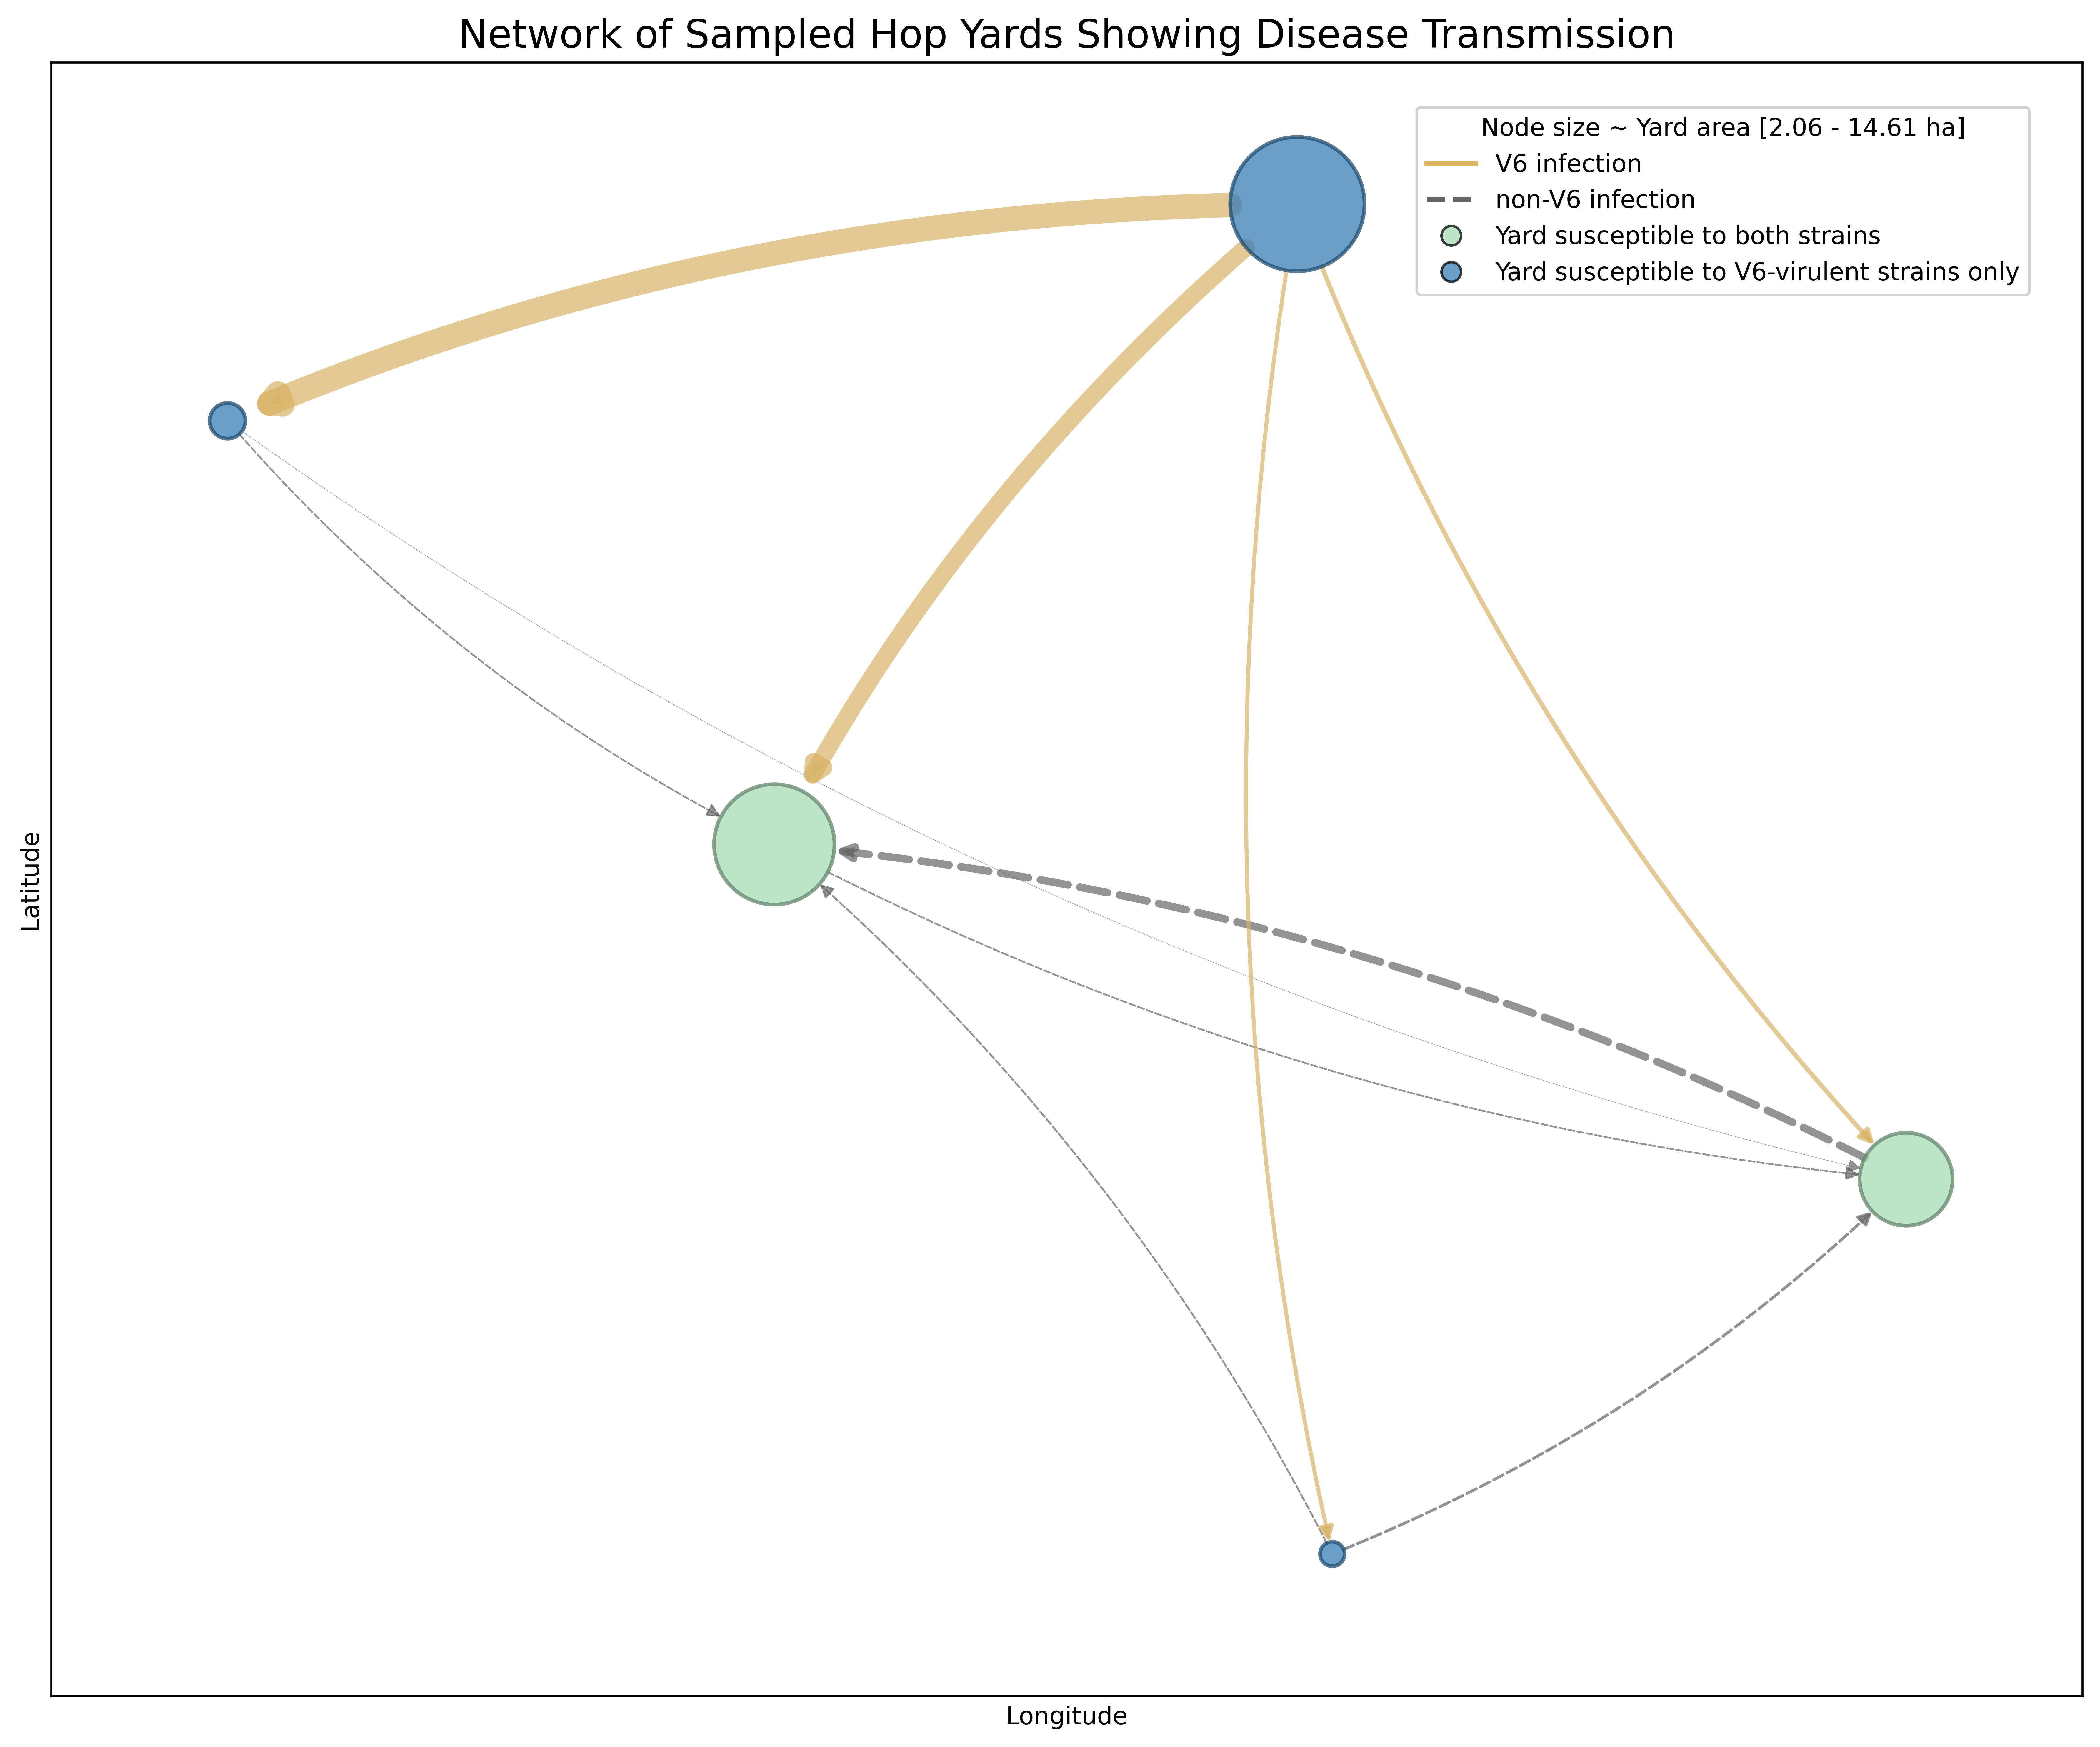

In [74]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # Ensure this is imported
from matplotlib.colors import to_rgba # Import for color conversion
import numpy as np
import math # Needed for checking isnan
import pandas as pd # Ensure pandas is imported

# ==============================================================================
# Network Visualization for Sampled Nodes (One per *Other* Centrality Quantile) # <<< UPDATED
# - Node size ~ Area (area_hectares)
# - Edge width ~ Directed Weight (Area*Wind*Dist^-2) from new DiGraph G [LINEAR SCALING]
# - Enhanced Node Appearance (Transparency + Darker Border)
# ==============================================================================

# --- Parameters ---
LAYOUT_SEED = 21
MIN_NODE_SIZE = 100
MAX_NODE_SIZE = 3000
MIN_EDGE_WIDTH = 0.2
MAX_EDGE_WIDTH = 10.0

# --- Edge Color Parameters ---
base_color_sI1_rgba = to_rgba('#d8b365')  # Color for edges where source sI=1
base_color_sI0_rgba = to_rgba('#666666')  # Color for edges where source sI=0

# --- Node Appearance Parameters ---
NODE_ALPHA = 0.75
NODE_BORDER_WIDTH = 1.5
NODE_BORDER_DARKEN_FACTOR = 0.6
# *** ADJUST APPEARANCE PARAMETERS AS NEEDED ***

# --- Assumes the following variables exist from your preceding code ---
# G:                 The NEW nx.DiGraph object. <<< IMPORTANT (Must be DiGraph)
# degree_centrality_df: DataFrame with 'Node', 'Centrality_quantile_norm'. <<< IMPORTANT COLUMN
# coord:             DataFrame with 'Centroid Lat', 'Centroid Long'.
# sI1_may:           Numpy array sI=0/1.
# tI1:               Numpy array or source tI=0/1.
# area_hectares:     Numpy array/list area.
# year:              (Optional) The year.
# num_quantiles:     (Optional but helpful for context) The number of quantiles.
#---------------------------------------------------------------------

# --- Check for prerequisite Directed Graph G ---
if 'G' not in locals() and 'G' not in globals(): raise NameError("Directed NetworkX graph 'G' not found.")
if not isinstance(G, nx.DiGraph): raise TypeError("Variable 'G' is not a NetworkX DiGraph object.")

print("\n--- Creating NetworkX graph for Sampled Nodes (1 per *Other* Centrality Quantile) ---") # <<< UPDATED

# --- 1. Sample One Node per *Other* Centrality Quantile Norm --- # <<< NEW SAMPLING LOGIC
if 'degree_centrality_df' not in locals() and 'degree_centrality_df' not in globals():
     raise NameError("DataFrame 'degree_centrality_df' not found.")
# <<< Ensure the correct normalized quantile column exists >>>
if 'Centrality_quantile_norm' not in degree_centrality_df.columns:
     raise KeyError("Column 'Centrality_quantile_norm' not found in degree_centrality_df. Ensure it was calculated.")

# Prepare DataFrame (ensure 'Node' is a column)
if 'Node' not in degree_centrality_df.columns:
     if degree_centrality_df.index.name == 'Node': degree_centrality_df_reset = degree_centrality_df.reset_index()
     else:
          print("WARN: 'Node' column not found..."); degree_centrality_df_reset = degree_centrality_df.reset_index()
          if not pd.api.types.is_numeric_dtype(degree_centrality_df_reset['index']): raise ValueError("Could not identify Node IDs.")
          degree_centrality_df_reset = degree_centrality_df_reset.rename(columns={'index': 'Node'})
else:
    degree_centrality_df_reset = degree_centrality_df.copy()

# --- Determine target quantile norm values ---
# Get unique norm values, sort descending
unique_norms = sorted(degree_centrality_df_reset['Centrality_quantile_norm'].unique(), reverse=True)
# Select every other value starting from the first (highest)
target_norm_values = unique_norms[::2] # Slice with step 2
print(f"Targeting quantile norm values for sampling: {target_norm_values}")

# --- Filter DataFrame to include only target quantiles ---
filtered_df = degree_centrality_df_reset[
    degree_centrality_df_reset['Centrality_quantile_norm'].isin(target_norm_values)
]

if filtered_df.empty:
     print("WARN: No nodes found matching the target quantile norm values. Cannot sample.")
     exit()

# --- Group by the target norm values and sample 1 from each ---
print(f"Sampling 1 node from each of the {len(target_norm_values)} targeted quantiles using seed {LAYOUT_SEED}...")
sampled_df = filtered_df.groupby('Centrality_quantile_norm', observed=True).sample(n=1, random_state=LAYOUT_SEED)
sampled_node_ids = sampled_df['Node'].tolist()
# --- End of New Sampling Logic ---


if not sampled_node_ids:
    print("WARN: No nodes were sampled (unexpected). Cannot create graph.")
    exit()
else:
    print(f"Sampled {len(sampled_node_ids)} nodes.")

# --- [Step 2: Attribute Extraction - Remains the Same] ---
# (Code for extracting pos, sI, tI, area, centrality for sampled_node_ids is identical)
# ... (Attribute extraction code runs here) ...
# --- [Step 2: Attribute Extraction - Remains the Same] ---
print("Extracting attributes...")
if not coord.index.name == 'Node':
     if 'Node' in coord.columns: coord = coord.set_index('Node')
     elif coord.index.equals(pd.RangeIndex(len(coord))): print("WARN: Assuming coord index == Node ID."); coord.index.name = 'Node'
     else: raise ValueError("Cannot determine Node IDs in 'coord'.")
sampled_coord = coord.loc[sampled_node_ids]; pos = {nid: (r['Centroid Long'], r['Centroid Lat']) for nid, r in sampled_coord.iterrows()}
target_sI, target_tI, target_areas, target_centrality = {}, {}, {}, {}
try: tI1_flat=tI1.flatten(); tI1_dict={i: tI1_flat[i] for i in range(len(tI1_flat))}
except NameError: raise NameError("'tI1' not found.")
except Exception as e: raise TypeError(f"Could not convert tI1: {e}")
original_sampled_ids = sampled_node_ids.copy(); valid_sampled_node_ids = []
for node_id in original_sampled_ids:
    try:
        target_sI[node_id]=int(sI1_may[node_id][0] if sI1_may.ndim>1 else sI1_may[node_id])
        target_tI[node_id]=int(tI1_dict.get(node_id, np.nan))
        target_areas[node_id]=float(area_hectares[node_id][0] if area_hectares.ndim>1 else area_hectares[node_id])
        valid_sampled_node_ids.append(node_id)
    except Exception as e: print(f"WARN: Error attributes node {node_id}: {e}. Skipping.");
    if node_id in pos and node_id not in valid_sampled_node_ids: del pos[node_id]
sampled_node_ids=valid_sampled_node_ids;
# Get centrality from the FULL df initially used for sampling, before filtering/grouping, to ensure we have it.
target_centrality=degree_centrality_df_reset[degree_centrality_df_reset['Node'].isin(sampled_node_ids)].set_index('Node')['Centrality'].to_dict()
sampled_node_ids=[nid for nid in sampled_node_ids if nid in target_centrality] # Final check for centrality
if not sampled_node_ids: print("ERROR: No nodes remaining."); exit()


# --- [Step 3: Create Graph - Remains the Same] ---
G_sampled = nx.DiGraph()
# ... (Node addition loop is the same) ...
nodes_added_count = 0
for node_id in sampled_node_ids:
    node_area = target_areas.get(node_id, np.nan); node_centrality = target_centrality.get(node_id, np.nan)
    node_sI = target_sI.get(node_id, None); node_tI = target_tI.get(node_id, None)
    is_area_valid = isinstance(node_area, (int, float)) and not math.isnan(node_area) and node_area >= 0
    is_centrality_valid = isinstance(node_centrality, (int, float)) and not math.isnan(node_centrality)
    if not is_area_valid: node_area = 0.0
    if node_sI is None or node_tI is None or not is_centrality_valid: print(f"WARN: Node {node_id} missing critical attribute. Skipping add."); continue
    G_sampled.add_node(node_id, sI=node_sI, tI=node_tI, area=node_area, centrality=node_centrality)
    nodes_added_count += 1
print(f"Added {nodes_added_count} nodes to the sampled graph.")


# --- [Step 4: Add Edges - Remains the Same] ---
edge_weights_in_sample = []
# ... (Edge addition loop fetching directed weight from G is the same) ...
if nodes_added_count >= 2:
    print("Adding edges between sampled nodes based on sI/tI logic...")
    print("   Fetching DIRECTED edge weights from the new graph 'G'...")
    edges_added_count = 0
    for i in G_sampled.nodes():
        for j in G_sampled.nodes():
            if i == j: continue
            node_i_sI = G_sampled.nodes[i]['sI']; node_j_tI = G_sampled.nodes[j]['tI']
            if node_i_sI == 1 or (node_i_sI == 0 and node_j_tI == 0):
                directed_weight_ij = 0.0
                if G.has_edge(i, j):
                    edge_data = G.get_edge_data(i, j)
                    if edge_data and 'weight' in edge_data:
                         weight_val = edge_data['weight']
                         if isinstance(weight_val, (int, float)) and not math.isnan(weight_val) and weight_val >= 0: directed_weight_ij = weight_val
                         else: print(f"WARN: Invalid weight for edge {i}->{j} in G ({weight_val}). Using 0.")
                    else: print(f"WARN: Edge ({i}->{j}) found in G but missing 'weight'. Using 0.")
                G_sampled.add_edge(i, j, weight=directed_weight_ij); edge_weights_in_sample.append(directed_weight_ij); edges_added_count += 1
    print(f"Added {edges_added_count} directed edges to sampled graph.")
else: print("Skipping edge creation.");


# --- [Step 5: Visualize - Calculation Logic Remains the Same, Title Updated] ---
print("Visualizing the sampled network...")
# ... (Node size calculation code is the same) ...
node_sizes = []; areas_in_sample=[d['area'] for n,d in G_sampled.nodes(data=True)]; valid_areas=[a for a in areas_in_sample if isinstance(a,(int,float)) and not math.isnan(a) and a>=0]
if not valid_areas: min_area,max_area=0.0,0.0
else: min_area=min(valid_areas); max_area=max(valid_areas)
area_range=max_area-min_area; print(f"Areas in sample range: {min_area:.2f}-{max_area:.2f} ha."); default_size=(MIN_NODE_SIZE+MAX_NODE_SIZE)/2
for node_id in G_sampled.nodes():
    area = G_sampled.nodes[node_id].get('area', 0.0)
    if area_range > 1e-9: scaled_size=MIN_NODE_SIZE+max(0.0,min(1.0,(area-min_area)/area_range))*(MAX_NODE_SIZE-MIN_NODE_SIZE)
    else: scaled_size=default_size
    node_sizes.append(max(MIN_NODE_SIZE, scaled_size))

# ... (Node color calculation code is the same) ...
node_fill_colors, node_border_colors = [], []; print("Calculating node fill/border colors...")
for node_id in G_sampled.nodes():
     node_tI=G_sampled.nodes[node_id]['tI']; fill_color_hex='#CCCCCC'
     if node_tI==0: fill_color_hex='#a8ddb5'
     elif node_tI==1: fill_color_hex='#377eb8'
     node_fill_colors.append(fill_color_hex)
     try: rgb_fill=mcolors.to_rgb(fill_color_hex); rgb_border=tuple(max(0.0,c*NODE_BORDER_DARKEN_FACTOR) for c in rgb_fill); node_border_colors.append(rgb_border)
     except ValueError: print(f"WARN: Invalid fill color {fill_color_hex}."); node_border_colors.append((0,0,0))

# ... (Edge styling - color/style and LINEAR width scaling - code is the same) ...
edge_rgba_colors, edge_widths, edge_styles = [], [], []
if G_sampled.number_of_edges() > 0:
    print("Calculating edge styles and colors based on sI...")
    for u, v, data in G_sampled.edges(data=True):
        alpha=0.7; source_sI=G_sampled.nodes[u]['sI']
        if source_sI==1: base_color, style = base_color_sI1_rgba, 'solid'
        elif source_sI==0: base_color, style = base_color_sI0_rgba, 'dashed'
        else: base_color, style = to_rgba('#FF00FF'), 'dotted'
        edge_styles.append(style); edge_rgba_colors.append((base_color[0], base_color[1], base_color[2], alpha))

    print("Scaling edge widths linearly based on directed weight...")
    valid_weights = [w for w in edge_weights_in_sample if isinstance(w, (int, float)) and not math.isnan(w) and w >= 0]
    if not valid_weights: min_weight, max_weight = 0.0, 0.0
    else: min_weight = min(valid_weights); max_weight = max(valid_weights)
    weight_range = max_weight - min_weight
    print(f"Directed weights range: {min_weight:.4f} to {max_weight:.4f}.")
    default_width = (MIN_EDGE_WIDTH + MAX_EDGE_WIDTH) / 2.0
    for weight in edge_weights_in_sample:
         if not isinstance(weight, (int, float)) or math.isnan(weight) or weight < 0: edge_widths.append(MIN_EDGE_WIDTH); continue
         if weight_range > 1e-9:
             normalized_weight = max(0.0, min(1.0, (weight - min_weight) / weight_range))
             scaled_width = MIN_EDGE_WIDTH + normalized_weight * (MAX_EDGE_WIDTH - MIN_EDGE_WIDTH)
         else: scaled_width = default_width if min_weight > 1e-9 else MIN_EDGE_WIDTH
         edge_widths.append(max(MIN_EDGE_WIDTH, scaled_width))
    if len(edge_widths)!=G_sampled.number_of_edges() or len(edge_rgba_colors)!=G_sampled.number_of_edges() or len(edge_styles)!=G_sampled.number_of_edges(): raise ValueError("Mismatch edge lists!")
else: min_weight, max_weight = 0.0, 0.0


# --- Draw the sampled network ---
plt.figure(figsize=(12, 10), dpi=600)
# ... (Position validation is the same) ...
valid_pos = {node: pos[node] for node in G_sampled.nodes() if node in pos}
if len(valid_pos) != G_sampled.number_of_nodes(): print(f"WARN: Position data missing...")

# ... (Node drawing is the same) ...
nx.draw_networkx_nodes(G_sampled, valid_pos, node_color=node_fill_colors, node_size=node_sizes, alpha=NODE_ALPHA, linewidths=NODE_BORDER_WIDTH, edgecolors=node_border_colors)
# ... (Edge drawing is the same) ...
if G_sampled.number_of_edges() > 0: nx.draw_networkx_edges(G_sampled, valid_pos, edge_color=edge_rgba_colors, style=edge_styles, width=edge_widths, arrowstyle='-|>', arrowsize=12, node_size=node_sizes, connectionstyle='arc3,rad=0.1')
else: print("No edges to draw.")

# (Labels removed)
# (Legend remains the same)
# ... (Legend code is the same) ...
legend_elements = [plt.Line2D([0],[0],color='#d8b365',lw=2,label='V6 infection',ls='solid'), plt.Line2D([0],[0],color='#666666',lw=2,label='non-V6 infection',ls='dashed'), plt.Line2D([0],[0],marker='o',ms=8,mfc='#a8ddb5',mec='black',alpha=NODE_ALPHA,label='Yard susceptible to both strains',ls='None'), plt.Line2D([0],[0],marker='o',ms=8,mfc='#377eb8',mec='black',alpha=NODE_ALPHA,label='Yard susceptible to V6-virulent strains only',ls='None')]
leg = plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=10, frameon=True)
leg.get_frame().set_alpha(0.9)
leg.get_frame().set_facecolor('white')
leg.set_title(f"Node size ~ Yard area [{min_area:.2f} - {max_area:.2f} ha]", prop={'size':10})


# <<< MODIFIED Title to reflect new sampling method >>>
# title_str = f"Network of Sampled Nodes (1 per Other Centrality Quantile Norm, Seed={LAYOUT_SEED})\n" # <<< UPDATED
# title_str += f"(Node Size ~ Area [{min_area:.2f}-{max_area:.2f} ha], "
# if G_sampled.number_of_edges() > 0 : title_str += f"Edge Width ~ Directed Physical Weight [{min_weight:.3f}-{max_weight:.3f}])"
# else: title_str += "Edge Width ~ Directed Physical Weight [No Edges])"
plt.title('Network of Sampled Hop Yards Showing Disease Transmission', fontsize=16)


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

# Save the figure before showing it
plt.savefig('../reports/figures/network_sampled_nodes_centrality_quantiles.png', 
            dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

# --- End of Network Visualization ---

In [57]:
# simulations = 100 # MAIN
simulations = 10

# Specify quantiles for distance-based simulations
quantiles = (np.arange(1, num_quantiles+1) / num_quantiles).tolist()

# Specify the v6-pathogen strain initial proportions across the entire landscape
# percentages = [0.0, 0.25, 0.50, 0.75, 1.0] # MAIN
percentages = [0.5]


# Specify the number of sprays applied in May for yards in given quantiles
# increments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # MAIN
increments = [0]

# Specify initial probabilities for infections across the landscape
# initial_probabilities = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01] # MAIN
initial_probabilities = [0.001]

quantile_list = []
sprays_in_May_list = []
V6_percent_list = []
initial_prob_list = []
simulation_list = []

# SYNTHETIC SPRAY DATA / POISSON REGRESSION

# MAY-JUNE
# Define the dependent (response) variable and the independent (predictor) variable
X_may = df[(df['Month'] == 'May')]['Mildew Incidence'].reset_index(drop=True)
y_jun = df[(df['Month'] == 'June')]['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_may = sm.add_constant(X_may)

# Fit the Poisson regression model
pois_may_jun = sm.GLM(y_jun, X_may, family=sm.families.Poisson()).fit()

# JUNE-JULY
# Define the dependent (response) variable and the independent (predictor) variable
X_jun = df[(df['Month'] == 'June')]['Mildew Incidence'].reset_index(drop=True)
y_jul = df[(df['Month'] == 'July')]['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_jun = sm.add_constant(X_jun)

# Fit the Poisson regression model
pois_jun_jul = sm.GLM(y_jul, X_jun, family=sm.families.Poisson()).fit()

# JULY-LATE SEASON
late_df = pd.read_csv('../data/processed/late_cost_data.csv', encoding='utf-8')
late_df = late_df[late_df['Year'] == year].reset_index(drop=True)

# Define the dependent (response) variable and the independent (predictor) variable
X_jul = df[(df['Month'] == 'July')]['Mildew Incidence'].reset_index(drop=True)
y_late = late_df['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_jul = sm.add_constant(X_jul)

# Fit the Poisson regression model
pois_jul_late = sm.GLM(y_late, X_jul, family=sm.families.Poisson()).fit()
# END JULY-LATE SEASON

# FUNCTION TO PREDICT SPRAYS GIVEN MILDEW INCIDENCE

# Function to predict number of sprays in a given period using the period before
def predict_sprays(period, mildew_values):

    if period == 'may-jun':
        # Flatten the input and convert to DataFrame
        mildew_values = np.array(mildew_values).flatten()
        input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
        input_df = sm.add_constant(input_df, has_constant='add')

        # Predict the number of sprays using the pois_may_jun model
        predicted_sprays = pois_may_jun.predict(input_df)
        predicted_sprays = predicted_sprays.values
        predicted_sprays = predicted_sprays.reshape(-1, 1)

    elif period == 'jun-jul':
        # Flatten the input and convert to DataFrame
        mildew_values = np.array(mildew_values).flatten()
        input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
        input_df = sm.add_constant(input_df, has_constant='add')

        # Predict the number of sprays using the pois_jun_jul model
        predicted_sprays = pois_jun_jul.predict(input_df)
        predicted_sprays = predicted_sprays.values
        predicted_sprays = predicted_sprays.reshape(-1, 1)

    elif period == 'late-season':
        # Flatten the input and convert to DataFrame
        mildew_values = np.array(mildew_values).flatten()
        input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
        input_df = sm.add_constant(input_df, has_constant='add')

        # Predict the number of sprays using the pois_jul_late model
        predicted_sprays = pois_jul_late.predict(input_df)
        predicted_sprays = predicted_sprays.values
        predicted_sprays = predicted_sprays.reshape(-1, 1)

    return predicted_sprays

# Mean sprays in May when mildew incidence is 0
lambda_may_0 = df[((df['Month'] == 'May') & (df['Mildew Incidence'] == 0))]['Sprays'].mean()

def sprays_may(infections, lambda_may):

    if (type(infections) == int) or (type(infections) == float) or (type(infections) == np.float64):

        if infections == 0:
            sprays_may = np.random.poisson(lambda_may_0)
            # sprays_may = 0

        else:
            sprays_may = np.random.poisson(lambda_may)

    else:

        sprays_may = np.zeros((len(infections), 1))

        for i in range(len(infections)):

            if infections[i] == 0:
                sprays_may[i] = np.random.poisson(lambda_may_0)

            else:
                sprays_may[i] = np.random.poisson(lambda_may)

    return sprays_may

# Function to create and modify the sI1_lag array by varying the number of yards that may contain V6-pathogen strains
def modify_array_by_quantile(percentage):
    N = len(centrality_quantile)
    modified_arr = np.zeros(N, dtype=int)
    quantiles = np.unique(centrality_quantile)

    for quant in quantiles:
        # Get indices for the current quantile
        indices = np.where(centrality_quantile == quant)[0]
        n_yards_quantile = len(indices)

        # Calculate the number of ones for this quantile
        num_ones_quantile = np.round(n_yards_quantile * percentage).astype(int)

        # Create an array with the required number of ones and zeros
        quantile_arr = np.array([1]*num_ones_quantile + [0]*(n_yards_quantile - num_ones_quantile))

        # Shuffle the array to randomize the distribution
        np.random.shuffle(quantile_arr)

        # Assign the shuffled array to the corresponding indices
        modified_arr[indices] = quantile_arr

    return modified_arr.reshape(N, 1)

# BEGIN SIMULATIONS

y_0_list = []
y_1_list = []
y_2_list = []

for simulation in range(simulations):
    # Update and reset the simulations progress bar
    
    for percent in percentages:
        
        # Modify the sI1_lag array by varying the number of yards that may contain V6-pathogen strains
        sI1_lag = modify_array_by_quantile(percent)

        for init_prob in initial_probabilities:
            
            for quant in quantiles:
                
                for lambda_may in increments:
                    
                    # Number of yards in the current quantile
                    num_yards_quantile = (centrality_quantile == quant).sum()

                    # Proportion of landscape in the current quantile
                    prop_yards_quantile = num_yards_quantile / N

                    # Proportion of yards in current quantile that may possess the v6 initial strain
                    prop_v6 = sI1_lag[np.where(centrality_quantile == quant)].mean()

                    # Proportion of yards in current quantile that are susceptible to both v6 and non-v6 strains
                    prop_susceptible_both = tI2[np.where(centrality_quantile == quant)].mean()

                    # Proportion of plants that are susceptible to disease in each quantile of the network
                    prop_susceptible = prop_susceptible_both * (1 + prop_v6)

                    # Adjust initial probability by concentrating infections in the susceptible yards and quantiles
                    adjusted_init_prob = init_prob * (1 / prop_susceptible) * (1 / prop_yards_quantile)

                    # Create y_0, containing the number of initial flagshoots in May
                    y_0 = np.random.binomial(n, adjusted_init_prob, size=(N, 1))
                    
                    for k in range(N):

                        # If the yard is not affected by the V6-pathogen strain and the yard is only,
                        # susceptible to V6 strain, set the number of initial flagshoots to 0
                        if (y_0[k] > 0) and (tI1[k] == 1) and (sI1_lag[k] == 0):
                            y_0[k] = 0

                        if centrality_quantile[k] != quant:
                            y_0[k] = 0
                    
                    # Calculate the number of sprays in May
                    sprays_0 = sprays_may(y_0, lambda_may=lambda_may)
                    
                    # Estimate y_1, the number of infections in June
                    y_1 = prob(period='may-jun', y_lag=y_0, sprays=sprays_0) * n

                    # Calculate the number of sprays in June
                    sprays_1 = predict_sprays('may-jun', y_0/n)
                    
                    # Estimate y_2, the number of infections in July
                    y_2 = prob(period='jun-jul', y_lag=y_1, sprays=sprays_1) * n
                    
                    # Calculate the number of sprays in July
                    sprays_2 = predict_sprays('jun-jul', y_1/n)
                    
                    # Calculate the number of sprays in the late season
                    sprays_late = predict_sprays('late-season', y_2/n)
                    
                    
                    quantile_list.append(quant)
                    sprays_in_May_list.append(lambda_may)
                    V6_percent_list.append(percent)
                    initial_prob_list.append(init_prob)
                    simulation_list.append(simulation)
                    y_0_list.append(y_0)
                    y_1_list.append(y_1)
                    y_2_list.append(y_2)
                    
# Mean disease levels over all simulations
y_0_mean = np.mean(np.array(y_0_list), axis=0)
y_1_mean = np.mean(np.array(y_1_list), axis=0)
y_2_mean = np.mean(np.array(y_2_list), axis=0)

In [58]:
y_0_mean

array([[0.49],
       [0.45],
       [0.53],
       [0.4 ],
       [0.39],
       [0.47],
       [0.44],
       [0.49],
       [0.15],
       [0.14],
       [0.3 ],
       [0.67],
       [0.37],
       [0.32],
       [0.48],
       [1.02],
       [0.26],
       [0.81],
       [0.48],
       [0.23],
       [0.27],
       [0.34],
       [0.55],
       [0.36],
       [0.86],
       [0.32],
       [0.88],
       [0.24],
       [0.32],
       [0.36],
       [0.08],
       [0.56],
       [0.72],
       [0.4 ],
       [0.55],
       [0.58],
       [0.32],
       [0.37],
       [0.4 ],
       [0.56],
       [0.43],
       [0.16],
       [0.29],
       [0.42],
       [0.37],
       [0.27],
       [0.43],
       [0.59],
       [0.18],
       [0.4 ],
       [0.51],
       [0.19],
       [0.18],
       [0.32],
       [0.35],
       [0.15],
       [0.81],
       [0.14],
       [0.61],
       [0.15],
       [0.15],
       [0.37],
       [0.38],
       [0.13],
       [0.42],
       [0.72],
       [0.

In [59]:
theta_may_jun

# set precision
np.set_printoptions(precision=10, suppress=True)
theta_may_jun

theta_jun_jul

array([[  -2.785954493 ],
       [  -3.8837032423],
       [   2.938782895 ],
       [   8.0439297571],
       [1390.7076209352],
       [ 286.8022464531],
       [   1.0006846315],
       [   2.0400502763],
       [   0.0238317252],
       [   0.308224747 ],
       [   0.9494636118],
       [   0.3651273522]])

In [60]:
prob('jun-jul', 1, 0)

array([[0.0206156236],
       [0.0206202887],
       [0.0206167977],
       [0.0594839426],
       [0.0206136821],
       [0.0594769859],
       [0.0206155394],
       [0.0206186272],
       [0.059444683 ],
       [0.0596760847],
       [0.0596822554],
       [0.0597050651],
       [0.0206307966],
       [0.0206274625],
       [0.0206154512],
       [0.0205813901],
       [0.0589487128],
       [0.0205761832],
       [0.0206049404],
       [0.0594672227],
       [0.0598592629],
       [0.0205930923],
       [0.0590864905],
       [0.0595702388],
       [0.0206148423],
       [0.0206093556],
       [0.0206244612],
       [0.059648314 ],
       [0.0592442308],
       [0.0206374969],
       [0.0594795807],
       [0.0206368798],
       [0.0597078588],
       [0.0598460416],
       [0.0206273476],
       [0.0595445842],
       [0.0596399541],
       [0.0206277744],
       [0.0206226336],
       [0.059615165 ],
       [0.0595367591],
       [0.0593265178],
       [0.059449803 ],
       [0.0

In [61]:
# Check the shapes first to understand the mismatch
print(f"X_jul shape: {X_jul.shape}")
print(f"y_late shape: {y_late.shape}")

X_jul shape: (122, 2)
y_late shape: (122,)


In [62]:

# from sklearn.preprocessing import StandardScaler # Import only if using scaling below

# ==============================================================================
# Clustering, Analysis, and Mapping Section
# ==============================================================================
# --- Assumes the following variables exist from your preceding code ---
# coord: pandas DataFrame with 'Centroid Lat', 'Centroid Long', indexed 0 to N-1
# degree_centrality_df: pandas DataFrame with 'Node' (0 to N-1), 'Centrality'
# N: Integer, total number of yards
# k_clusters: Integer, the desired number of clusters (e.g., 10)
# year: Integer, the current year (optional, used for filename)
# --------------------------------------------------------------------

k_clusters = 10

# Check if k_clusters is defined, provide a default if not (adjust as needed)
if 'k_clusters' not in locals() and 'k_clusters' not in globals():
    k_clusters = 10 # Default if not defined earlier in your script
    print(f"INFO: 'k_clusters' not found, using default value: {k_clusters}")

# --- 1. Prepare Data for Clustering ---
# Make sure 'coord' DataFrame is ready from your previous code.
# Example: Ensure index is simple if needed (might not be necessary depending on your code)
# coord = coord.reset_index(drop=True)
coords_for_clustering = coord[['Centroid Long', 'Centroid Lat']].values

# Optional: Scale coordinates (uncomment below and ensure StandardScaler is imported)
# print("Scaling coordinates for clustering...")
# scaler = StandardScaler()
# coords_scaled = scaler.fit_transform(coords_for_clustering)
# Use coords_scaled in KMeans below if uncommented

# --- 2. Perform Clustering ---
print(f"\nPerforming KMeans clustering with k={k_clusters}...")
kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
# cluster_labels = kmeans.fit_predict(coords_scaled) # Use if scaled
cluster_labels = kmeans.fit_predict(coords_for_clustering) # Use if not scaled

# Add cluster labels directly to the main DataFrame that has coordinates and node info
# It's often better to merge later, but adding directly to coord if its index matches nodes 0..N-1
if coord.index.equals(pd.RangeIndex(start=0, stop=N, step=1)):
    coord['Cluster'] = cluster_labels
    print("Added 'Cluster' column to 'coord' DataFrame.")
else:
    # If coord index is not standard, create a temporary mapping
    cluster_mapping = pd.DataFrame({'Node': coord.index, 'Cluster': cluster_labels}) # Assumes coord index ARE the node IDs
    print("Created temporary cluster mapping.")
    # You will need to merge cluster_mapping with your main DataFrame later if needed


# --- Assumes tI1 (Nx1 numpy array) exists from your simulation setup code ---
# Example: tI1 = arr[:, 0].reshape(N, 1) # Make sure this is defined before this step

# --- 3. Calculate Summed Centrality, Counts, and Prepare Analysis DF ---
# Merge cluster labels with centrality scores and tI1 data.
# This requires DataFrames that correctly link Node ID, Cluster Label, Centrality, and tI1.

print("\nPreparing analysis DataFrame by merging cluster, centrality, and tI data...")

# Create a DataFrame for tI1 to merge easily
# Ensure tI1 is flattened if it's a column vector
try:
    tI1_flat = tI1.flatten()
except AttributeError:
     tI1_flat = tI1 # Assume it's already flat if no flatten() method
tI1_df = pd.DataFrame({'Node': np.arange(N), 'tI1': tI1_flat})

# Option A: If 'Cluster' was added directly to 'coord' and 'coord.index' is Node ID 0..N-1
if 'Cluster' in coord.columns and coord.index.equals(pd.RangeIndex(start=0, stop=N, step=1)):
     print("Merging based on coord index (Method A)...")
     # Merge coord+cluster with centrality, then merge with tI1
     cluster_analysis_df = pd.merge(coord.reset_index().rename(columns={'index':'Node'}), # Add Node from index
                                   degree_centrality_df,
                                   on='Node',
                                   how='inner') # Use inner merge to ensure matches
     cluster_analysis_df = pd.merge(cluster_analysis_df, tI1_df, on='Node', how='inner')
     print(f"Shape of cluster_analysis_df after merges: {cluster_analysis_df.shape}")

# Option B: If using the temporary mapping (assumes coord.index are Node IDs)
elif 'cluster_mapping' in locals() and coord.index.equals(pd.RangeIndex(start=0, stop=N, step=1)):
     print("Merging based on temporary mapping (Method B)...")
     # Merge coord with mapping, then with centrality, then with tI1
     temp_df = pd.merge(coord.reset_index().rename(columns={'index':'Node'}), # Add Node from index
                       cluster_mapping, # Contains 'Node' and 'Cluster'
                       on='Node',
                       how='inner')
     cluster_analysis_df = pd.merge(temp_df, degree_centrality_df, on='Node', how='inner')
     cluster_analysis_df = pd.merge(cluster_analysis_df, tI1_df, on='Node', how='inner')
     print(f"Shape of cluster_analysis_df after merges: {cluster_analysis_df.shape}")

# Fallback / Error Handling - Adjust if your structure is different
else:
     print("WARN: Could not use Method A or B for merging. Attempting fallback merge.")
     print("Ensure 'coord', 'degree_centrality_df', and 'tI1' can be linked via a common 'Node' identifier (0 to N-1).")
     try:
        # Attempt merge assuming 'Node' column might exist or index can be used
        base_df = coord.reset_index().rename(columns={'index':'Node'}) # Get Node from index if needed
        if 'Node' not in base_df.columns: # Check if 'Node' column existed in original coord
             # If not, maybe the index IS the node id
             print("Assuming coord.index represents Node ID for merging.")

        # Ensure cluster labels are linked correctly
        clusters_temp_df = pd.DataFrame({'Node': np.arange(N), 'Cluster': cluster_labels})

        # Perform merges step-by-step
        merged_df = pd.merge(base_df, clusters_temp_df, on='Node', how='inner')
        merged_df = pd.merge(merged_df, degree_centrality_df, on='Node', how='inner')
        cluster_analysis_df = pd.merge(merged_df, tI1_df, on='Node', how='inner')
        print(f"Shape of cluster_analysis_df after fallback merges: {cluster_analysis_df.shape}")
        if len(cluster_analysis_df) != N:
            print(f"WARN: Fallback merge resulted in {len(cluster_analysis_df)} rows, expected {N}. Check merge keys.")
     except Exception as e:
        print(f"ERROR: Failed to merge DataFrames: {e}")
        print("Cannot proceed without a valid 'cluster_analysis_df'. Please check your DataFrame structures and merge logic.")
        # Handle error appropriately, maybe raise exception or exit
        raise ValueError("Failed to create cluster_analysis_df for network visualization.")


# --- Ensure required columns exist ---
required_cols = ['Node', 'Centroid Lat', 'Centroid Long', 'Cluster', 'Centrality', 'tI1']
if not all(col in cluster_analysis_df.columns for col in required_cols):
    missing = [col for col in required_cols if col not in cluster_analysis_df.columns]
    raise ValueError(f"FATAL: cluster_analysis_df is missing required columns: {missing}")


# Group by cluster, sum 'Centrality', and get size (count)
cluster_summed_centrality = cluster_analysis_df.groupby('Cluster')['Centrality'].sum()
cluster_counts = cluster_analysis_df.groupby('Cluster').size()

print("\nSummed Weighted Degree Centrality per Cluster:")
print(cluster_summed_centrality)
print("\nYards per cluster:")
print(cluster_counts)

# --- Identify Highest Scoring Cluster and Filter Data ---
# (This part should already be in your code)
highest_centrality_cluster_label = cluster_summed_centrality.idxmax()
target_cluster_df = cluster_analysis_df[cluster_analysis_df['Cluster'] == highest_centrality_cluster_label].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"\nFiltered data for target cluster {highest_centrality_cluster_label}. Shape: {target_cluster_df.shape}")

# Select cluster 2
target_cluster_df = cluster_analysis_df[cluster_analysis_df['Cluster'] == 2].copy() # Use .copy() to avoid SettingWithCopyWarning

# --- End of Modified Step 3 ---


# --- 4. Visualization: Folium Map of ALL Clusters with Detailed Legend ---
print("\nGenerating Folium map with all yards colored by cluster and legend (including counts)...")

# --- Create Color Mapping ---
if k_clusters <= 10:
    cmap = cm.get_cmap('tab10', k_clusters)
elif k_clusters <= 20:
    cmap = cm.get_cmap('tab20', k_clusters)
else:
    cmap = cm.get_cmap('viridis', k_clusters)

cluster_colors = {}
for i in range(k_clusters):
    if hasattr(cmap, 'colors') and i < len(cmap.colors):
         cluster_colors[i] = mcolors.to_hex(cmap.colors[i])
    else:
         cluster_colors[i] = mcolors.to_hex(cmap(i / k_clusters))

# --- Create Base Folium Map (centered on ALL yards) ---
# Use the original 'coord' for centering, as cluster_analysis_df might change structure
map_center_lat_all = coord['Centroid Lat'].mean()
map_center_lon_all = coord['Centroid Long'].mean()
m_all_clusters = folium.Map(
    location=[map_center_lat_all, map_center_lon_all],
    zoom_start=11,
    tiles='CartoDB positron'  # <-- Add this parameter
)

# --- Add All Clustered Yards to Map ---
# Iterate through the DataFrame that contains coords, cluster, node, centrality
for index, row in cluster_analysis_df.iterrows():
    cluster_label = row['Cluster']
    node_id = row['Node']
    centrality = row['Centrality']
    color = cluster_colors.get(cluster_label, '#808080') # Default to gray

    folium.CircleMarker(
        location=(row['Centroid Lat'], row['Centroid Long']),
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=(f"Node: {node_id}<br>"
                 f"Cluster: {cluster_label}<br>"
                 f"Centrality: {centrality:.4f}")
    ).add_to(m_all_clusters)

# --- Create Custom HTML Legend (with Scores and Counts) ---
legend_html = '''
     <div style="
     position: fixed;
     bottom: 50px;
     left: 50px;
     width: 250px;
     height: auto;
     max-height: 300px; /* Scroll if legend is too long */
     overflow-y: auto;
     border:2px solid grey;
     z-index:9999;
     font-size:12px;
     background-color: white;
     opacity: 0.9;
     padding: 10px;
     border-radius: 5px;
     ">
     <b>Cluster Info</b><br>
     <span style="font-size:10px;">(Summed Score | Yard Count)</span>
     <hr style="margin-top: 5px; margin-bottom: 5px;">
     '''

sorted_scores = cluster_summed_centrality.sort_index()
for cluster_label, score in sorted_scores.items():
    color = cluster_colors.get(cluster_label, '#808080')
    count = cluster_counts.get(cluster_label, 0)
    legend_html += (f'<div style="margin-bottom: 3px;">'
                    f'<i style="background:{color}; width:15px; height:15px; display:inline-block; margin-right:5px; border:1px solid #ccc; vertical-align:middle;"></i>'
                    f' Cluster {cluster_label}: {score:.2f} | {count} yards'
                    f'</div>')

legend_html += '</div>'

legend = branca.element.Element(legend_html)
m_all_clusters.get_root().html.add_child(legend)

# --- Display or Save the Final Map ---
map_filename_all = f'all_clusters_map_with_counts'
try:
    # Use the 'year' variable if it exists from your preceding code
    map_filename_all += f'_year_{year}'
except NameError:
    print("INFO: 'year' variable not found, saving map without year in filename.")
map_filename_all += '.html'

m_all_clusters.save(map_filename_all)
print(f"\nMap with all clusters and counts saved to {map_filename_all}")

# Optional: Display map in Jupyter/IPython (uncomment below)
# from IPython.display import display
# print("\nDisplaying final map...")
# display(m_all_clusters)

# Optional: Open the saved HTML file automatically (uncomment below)
# import webbrowser
# import os
# print(f"Opening {map_filename_all} in browser...")
# webbrowser.open(f'file://{os.path.realpath(map_filename_all)}')


print("\n--- Clustering and Mapping Section Finished ---")

m_all_clusters


Performing KMeans clustering with k=10...
Added 'Cluster' column to 'coord' DataFrame.

Preparing analysis DataFrame by merging cluster, centrality, and tI data...
Merging based on coord index (Method A)...
Shape of cluster_analysis_df after merges: (122, 8)

Summed Weighted Degree Centrality per Cluster:
Cluster
0    0.012992
1    0.069120
2    0.017781
3    0.097602
4    0.097789
5    0.034998
6    0.003485
7    0.076521
8    0.002926
9    0.001363
Name: Centrality, dtype: float64

Yards per cluster:
Cluster
0     9
1    22
2    10
3    25
4    21
5    11
6     3
7    17
8     2
9     2
dtype: int64

Filtered data for target cluster 4. Shape: (21, 8)

Generating Folium map with all yards colored by cluster and legend (including counts)...


C:\Users\joshf\AppData\Local\Temp\ipykernel_36160\1664552410.py:152: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', k_clusters)



Map with all clusters and counts saved to all_clusters_map_with_counts_year_2017.html

--- Clustering and Mapping Section Finished ---


In [67]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba # Import for color conversion
import numpy as np
import math # Needed for checking isnan

# ==============================================================================
# Network Visualization for Target Cluster using Real Data
# ==============================================================================

# --- Parameters for Network Simulation ---
PLANTS_PER_YARD = 400
INFECTION_PROB = 0.02 # Binomial probability for infection simulation
                      # *** ADJUST THIS PROBABILITY AS NEEDED ***
LAYOUT_SEED = 123     # Seed for layout reproducibility

# --- Parameters for Node Size Scaling ---
MIN_NODE_SIZE = 100  # Minimum visual size of a node in pixels
MAX_NODE_SIZE = 3000 # Maximum visual size of a node in pixels
                     # *** ADJUST MIN/MAX SIZES AS NEEDED ***

# --- Assumes the following variables exist from your preceding code ---
# target_cluster_df: DataFrame filtered for the highest centrality cluster,
#                    containing 'Node', 'Centroid Lat', 'Centroid Long', 'tI1'.
# sI1_may:           The full (Nx1 or Nx?) numpy array containing sI=0/1 for all yards.
# area_hectares:     The full (Nx1 or N,) numpy array/list with area for all yards.
# highest_centrality_cluster_label: The label of the target cluster.
#---------------------------------------------------------------------

print(f"\n--- Creating NetworkX graph for Target Cluster {highest_centrality_cluster_label} ---")

# --- 1. Extract Data for Target Cluster Nodes ---
target_node_ids = target_cluster_df['Node'].tolist()
if not target_node_ids:
    print(f"WARN: Target cluster {highest_centrality_cluster_label} has no nodes. Skipping network visualization.")
else:
    # Create position dictionary {node_id: (lon, lat)}
    pos = {row['Node']: (row['Centroid Long'], row['Centroid Lat'])
           for index, row in target_cluster_df.iterrows()} # Corrected line

    # Create attribute dictionaries for target nodes
    try:
        # Assuming sI1_may might be (N, 1) or just (N,)
        target_sI = {node_id: int(sI1_may[node_id][0] if sI1_may.ndim > 1 else sI1_may[node_id])
                     for node_id in target_node_ids}
    except IndexError as e:
         raise IndexError(f"Error accessing sI1_may for node IDs. Check shape/indexing. Original error: {e}")

    target_tI = target_cluster_df.set_index('Node')['tI1'].astype(int).to_dict()

    # *** NEW: Extract areas for target nodes ***
    try:
        # Assuming area_hectares might be (N, 1) or just (N,)
        target_areas = {node_id: float(area_hectares[node_id][0] if area_hectares.ndim > 1 else area_hectares[node_id])
                        for node_id in target_node_ids}
    except IndexError as e:
         raise IndexError(f"Error accessing area_hectares for node IDs. Check shape/indexing. Original error: {e}")
    except TypeError as e:
         raise TypeError(f"Error converting area_hectares to float. Check data type. Original error: {e}")


    # --- 2. Create the Directed Graph ---
    G_target = nx.DiGraph()

    # Add nodes with attributes (sI, tI, and now area)
    for node_id in target_node_ids:
        G_target.add_node(node_id,
                          sI=target_sI[node_id],
                          tI=target_tI[node_id],
                          area=target_areas.get(node_id, 0.0)) # Store area attribute too
    print(f"Added {G_target.number_of_nodes()} nodes to the target graph.")

    # --- 3. Add Edges and Calculate Weights based on Infection Logic ---
    # (This section remains the same as before)
    print("Calculating edges and weights based on infection logic and simulation...")
    edge_count = 0
    simulated_weights = []
    for i in target_node_ids:
        for j in target_node_ids:
            if i == j: continue
            if target_sI[i] == 1 or (target_sI[i] == 0 and target_tI[j] == 0):
                infections_i = np.random.binomial(n=PLANTS_PER_YARD, p=INFECTION_PROB)
                infections_j = np.random.binomial(n=PLANTS_PER_YARD, p=INFECTION_PROB)
                total_infections = infections_i + infections_j
                total_plants_between = 2 * PLANTS_PER_YARD
                weight = total_infections / float(total_plants_between) if total_plants_between > 0 else 0.0
                weight = max(0.0, min(1.0, weight))
                G_target.add_edge(i, j, weight=weight)
                simulated_weights.append(weight)
                edge_count += 1
    # (Min/Max weight calculation remains the same)
    print(f"Added {edge_count} edges to the target graph.")
    if not simulated_weights: min_weight, max_weight, weight_range = 0.0, 0.0, 0.0
    else:
        min_weight = min(simulated_weights); max_weight = max(simulated_weights)
        weight_range = max_weight - min_weight
    print(f"Simulated edge weights range from {min_weight:.4f} to {max_weight:.4f}.")


    # --- 4. Visualize the Network ---
    print("Visualizing the target cluster network with node size scaled by area and dashed edges for sI=0...")

    if not G_target.nodes:
        print("Graph has no nodes. Cannot visualize.")
        # Exit or return if G_target is empty

    # --- Node Colors (based on tI) ---
    node_colors = ['#a8ddb5' if G_target.nodes[i]['tI'] == 0 else '#377eb8' for i in G_target.nodes()]

    # --- Calculate Scaled Node Sizes (based on area) ---
    # (This part remains the same as before)
    node_sizes = []
    areas_in_cluster = [data['area'] for node, data in G_target.nodes(data=True)]
    if not areas_in_cluster: min_area, max_area = 0.0, 0.0
    else: min_area = min(areas_in_cluster); max_area = max(areas_in_cluster)
    area_range = max_area - min_area
    print(f"Areas in target cluster range from {min_area:.2f} to {max_area:.2f} hectares.")
    default_size = (MIN_NODE_SIZE + MAX_NODE_SIZE) / 2
    for node_id in G_target.nodes():
        area = G_target.nodes[node_id].get('area', 0)
        if area_range > 1e-9: scaled_size = MIN_NODE_SIZE + ((area - min_area) / area_range) * (MAX_NODE_SIZE - MIN_NODE_SIZE)
        else: scaled_size = default_size
        node_sizes.append(max(MIN_NODE_SIZE, scaled_size))

    # --- Edge styling (Calculate colors, widths, AND styles) ---
    edge_rgba_colors = []
    base_color_sI1_rgba = to_rgba('#d8b365')
    base_color_sI0_rgba = to_rgba('#666666')
    edge_widths = []
    edge_styles = [] # *** NEW: List to store edge styles ***

    # Iterate through edges to determine style, color, width, alpha based on source node and weight
    for u, v, data in G_target.edges(data=True):
        weight = data.get('weight', 0.0)

        # Calculate alpha (opacity) based on weight (quadratic scaling)
        alpha = 0.0
        if weight_range > 1e-9:
            normalized_weight = max(0.0, min(1.0, (weight - min_weight) / weight_range))
            alpha = (normalized_weight ** 2) * 0.9
        elif max_weight > 1e-9: alpha = 0.9 if weight == max_weight else 0.0
        alpha = max(0.0, min(0.9, alpha))

        # Determine width
        edge_widths.append(0.8 + alpha * 1.2)

        # Determine base color and style based on source node's sI
        if G_target.nodes[u]['sI'] == 1:
            base_color = base_color_sI1_rgba
            edge_styles.append('solid') # *** sI=1 -> solid style ***
        else: # sI == 0
            base_color = base_color_sI0_rgba
            edge_styles.append('dashed') # *** sI=0 -> dashed style ***

        # Append RGBA color tuple
        edge_rgba_colors.append((base_color[0], base_color[1], base_color[2], alpha))

    arrowstyles = [ '-|>' for _ in G_target.edges()]

    # --- Draw the network ---
    plt.figure(figsize=(18, 10), dpi=600)

    # Draw nodes
    nx.draw_networkx_nodes(G_target, pos, node_color=node_colors, node_size=node_sizes)

    # Draw edges - *** MODIFIED: Added style parameter ***
    nx.draw_networkx_edges(G_target, pos, edge_color=edge_rgba_colors,
                           style=edge_styles, # <-- Pass the list of styles
                           arrowstyle=arrowstyles,
                           width=edge_widths,
                           arrowsize=12,
                           node_size=node_sizes, # IMPORTANT for edge clipping
                           connectionstyle='arc3,rad=0.1')

    # --- Labels are removed (as per previous request) ---
    # nx.draw_networkx_labels(...)

    # --- Create custom legend - *** MODIFIED: Updated sI=0 line style *** ---
    legend_elements = [
        plt.Line2D([0], [0], color='#d8b365', lw=2, label='Edge: Source sI=1 (Infects All)', linestyle='solid'), # Explicitly solid
        plt.Line2D([0], [0], color='#666666', lw=2, label='Edge: Source sI=0 (Infects tI=0)', linestyle='dashed'), # Changed to dashed
        plt.Line2D([0], [0], marker='o', markersize=8, markerfacecolor='#a8ddb5', markeredgecolor='black', label='Node: tI=0', linestyle='None'),
        plt.Line2D([0], [0], marker='o', markersize=8, markerfacecolor='#377eb8', markeredgecolor='black', label='Node: tI=1', linestyle='None'),
    ]
    leg = plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=10, frameon=True)
    leg.get_frame().set_alpha(0.9)
    leg.get_frame().set_facecolor('white')
    leg.set_title(f"Node size ~ Area [{min_area:.2f}-{max_area:.2f} ha]", prop={'size':10})

    # (Title, labels, layout, show remain the same)
    plt.title(f"Target Cluster {highest_centrality_cluster_label} Network (Node Size ~ Area, {INFECTION_PROB=:.3f})\n(Quadratic Opacity [0.0-0.9] for Weight [{min_weight:.3f}-{max_weight:.3f}])", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

# --- End of Network Visualization ---


--- Creating NetworkX graph for Target Cluster 4 ---
Added 10 nodes to the target graph.
Calculating edges and weights based on infection logic and simulation...
Added 59 edges to the target graph.
Simulated edge weights range from 0.0088 to 0.0350.
Visualizing the target cluster network with node size scaled by area and dashed edges for sI=0...
Areas in target cluster range from 1.34 to 13.31 hectares.


In [64]:
degree_centrality_df

Node  Centrality  Centrality_quantile_rank  Centrality_quantile_norm
0       0    0.000679                         1                       0.1
1       1    0.000713                         2                       0.2
2       2    0.000909                         2                       0.2
3       3    0.002060                         4                       0.4
4       4    0.000994                         2                       0.2
..    ...         ...                       ...                       ...
117   117    0.001201                         2                       0.2
118   118    0.008202                        10                       1.0
119   119    0.006287                         9                       0.9
120   120    0.003841                         7                       0.7
121   121    0.003050                         6                       0.6

[122 rows x 4 columns]

In [68]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba # Import for color conversion
import numpy as np
import math # Needed for checking isnan
import pandas as pd # Ensure pandas is imported if not already

# ==============================================================================
# Network Visualization for Target Cluster
# - Node size ~ Weighted Degree Centrality
# - Edge width/opacity ~ Simulated Disease Incidence
# ==============================================================================

# --- Parameters for Network Simulation (Used for Edge Weight/Thickness) ---
PLANTS_PER_YARD = 400
INFECTION_PROB = 0.04 # Binomial probability for infection simulation
                     # *** ADJUST THIS PROBABILITY AS NEEDED ***
LAYOUT_SEED = 123    # Seed for layout reproducibility

# --- Parameters for Node Size Scaling (Based on Centrality) --- # <<< CHANGE
MIN_NODE_SIZE = 100  # Minimum visual size of a node
MAX_NODE_SIZE = 3000 # Maximum visual size of a node
                     # *** ADJUST MIN/MAX SIZES AS NEEDED ***

# --- Parameters for Edge Width/Opacity Scaling (Based on Simulation) ---
# (These will be derived from the alpha calculation below)
MIN_EDGE_WIDTH_SIM = 0.8 # Base width
MAX_ALPHA_SCALING_SIM = 1.2 # Factor added based on alpha

# --- Assumes the following variables exist from your preceding code ---
# target_cluster_df: DataFrame filtered for the target cluster,
#                    containing 'Node', 'Centroid Lat', 'Centroid Long', 'tI1',
#                    and crucially 'Centrality'.
# sI1_may:           The full (Nx1 or Nx?) numpy array containing sI=0/1 for all yards.
# area_hectares:     The full (Nx1 or N,) numpy array/list with area for all yards (kept as attribute).
# highest_centrality_cluster_label: The label of the target cluster.
# degree_centrality_df: DataFrame with 'Node' and 'Centrality' for ALL nodes (used via target_cluster_df).
#---------------------------------------------------------------------

print(f"\n--- Creating NetworkX graph for Target Cluster {highest_centrality_cluster_label} ---")

# --- 1. Check if Centrality is present ---
if 'Centrality' not in target_cluster_df.columns:
    raise ValueError("FATAL: 'target_cluster_df' is missing the 'Centrality' column."
                     " Ensure it was calculated in Block 1 and merged correctly in Block 2.")

# --- 2. Extract Data for Target Cluster Nodes ---
target_node_ids = target_cluster_df['Node'].tolist()
if not target_node_ids:
    print(f"WARN: Target cluster {highest_centrality_cluster_label} has no nodes. Skipping network visualization.")
else:
    # Create position dictionary {node_id: (lon, lat)}
    pos = {row['Node']: (row['Centroid Long'], row['Centroid Lat'])
           for index, row in target_cluster_df.iterrows()}

    # Create attribute dictionaries for target nodes
    try:
        target_sI = {node_id: int(sI1_may[node_id][0] if sI1_may.ndim > 1 else sI1_may[node_id])
                     for node_id in target_node_ids}
    except IndexError as e:
        raise IndexError(f"Error accessing sI1_may for node IDs. Check shape/indexing. Original error: {e}")

    target_tI = target_cluster_df.set_index('Node')['tI1'].astype(int).to_dict()

    # Extract areas (store as attribute, but not used for sizing)
    try:
        target_areas = {node_id: float(area_hectares[node_id][0] if area_hectares.ndim > 1 else area_hectares[node_id])
                        for node_id in target_node_ids}
    except IndexError as e:
         print(f"WARN: IndexError accessing area_hectares for node IDs. Using 0. Original error: {e}")
         target_areas = {node_id: 0.0 for node_id in target_node_ids} # Fallback
    except TypeError as e:
        print(f"WARN: TypeError converting area_hectares to float. Using 0. Original error: {e}")
        target_areas = {node_id: 0.0 for node_id in target_node_ids}


    # Extract centrality (used for node sizing)
    target_centrality = target_cluster_df.set_index('Node')['Centrality'].to_dict()


    # --- 3. Create the Directed Graph ---
    G_target = nx.DiGraph()

    # Add nodes with attributes (sI, tI, area, and centrality)
    nodes_added_count = 0
    for node_id in target_node_ids:
        # Ensure centrality is valid before adding node
        node_centrality = target_centrality.get(node_id, np.nan) # Use NaN as default if missing
        if not isinstance(node_centrality, (int, float)) or math.isnan(node_centrality):
             print(f"WARN: Invalid or missing centrality for node {node_id}. Skipping node.")
             continue # Skip nodes without valid centrality

        G_target.add_node(node_id,
                          sI=target_sI.get(node_id), # Use .get() for safety
                          tI=target_tI.get(node_id),
                          area=target_areas.get(node_id, 0.0), # Store area
                          centrality=node_centrality) # Store centrality
        nodes_added_count += 1
    print(f"Added {nodes_added_count} nodes with valid centrality to the target graph.")

    # --- 4. Add Edges and Calculate Weights based on *Simulated Infection* Logic --- # <<< CHANGE BACK
    print("Calculating edges and simulated weights based on infection logic...")
    edge_count = 0
    simulated_weights = [] # To store weights for scaling edges
    edges_with_weights = [] # Store tuples (u, v, weight)

    for i in G_target.nodes(): # Iterate only over nodes actually added
        for j in G_target.nodes(): # Iterate only over nodes actually added
            if i == j: continue

            # Use original logic based on node attributes sI and tI
            node_i_sI = G_target.nodes[i]['sI']
            node_j_tI = G_target.nodes[j]['tI']

            # Check if attributes exist, handle if missing (though they should exist if node was added)
            if node_i_sI is None or node_j_tI is None:
                print(f"WARN: Missing sI/tI attribute for edge ({i}, {j}). Skipping edge.")
                continue

            if node_i_sI == 1 or (node_i_sI == 0 and node_j_tI == 0):
                # Simulate infections
                infections_i = np.random.binomial(n=PLANTS_PER_YARD, p=INFECTION_PROB)
                infections_j = np.random.binomial(n=PLANTS_PER_YARD, p=INFECTION_PROB)
                total_infections = infections_i + infections_j
                total_plants_between = 2 * PLANTS_PER_YARD

                # Calculate weight (simulated incidence)
                weight = total_infections / float(total_plants_between) if total_plants_between > 0 else 0.0
                weight = max(0.0, min(1.0, weight)) # Clamp between 0 and 1

                # Store edge and weight
                # G_target.add_edge(i, j, weight=weight) # Add edge with weight attribute
                edges_with_weights.append((i, j, weight))
                simulated_weights.append(weight)
                edge_count += 1

    # Add all edges at once
    for u, v, w in edges_with_weights:
        G_target.add_edge(u, v, weight=w)

    print(f"Added {edge_count} edges to the target graph.")
    if not simulated_weights: min_weight, max_weight, weight_range = 0.0, 0.0, 0.0
    else:
        min_weight = min(simulated_weights); max_weight = max(simulated_weights)
        weight_range = max_weight - min_weight
    print(f"Simulated edge weights range from {min_weight:.4f} to {max_weight:.4f}.")


    # --- 5. Visualize the Network ---
    print("Visualizing the target cluster network...")
    print("... Node size scaled by WEIGHTED DEGREE CENTRALITY.") # <<< CHANGE: Updated description
    print("... Edge width/opacity scaled by SIMULATED INCIDENCE.") # <<< CHANGE: Updated description
    print("... Edge style/color based on source node sI.")

    if not G_target.nodes:
        print("Graph has no nodes. Cannot visualize.")
        # Exit or return if G_target is empty
        exit() # Or use 'return' if in a function


    # --- Calculate Scaled Node Sizes (based on CENTRALITY) --- # <<< MAJOR CHANGE
    node_sizes = []
    centralities_in_cluster = [data['centrality'] for node, data in G_target.nodes(data=True)]

    if not centralities_in_cluster:
        min_centrality, max_centrality = 0.0, 0.0
        print("WARN: No valid centralities found in the cluster nodes.")
    else:
        # Filter out potential NaNs just in case, although node addition should prevent this
        valid_centralities = [c for c in centralities_in_cluster if isinstance(c, (int, float)) and not math.isnan(c)]
        if not valid_centralities:
             min_centrality, max_centrality = 0.0, 0.0
             print("WARN: No valid numeric centralities found after filtering.")
        else:
            min_centrality = min(valid_centralities)
            max_centrality = max(valid_centralities)

    centrality_range = max_centrality - min_centrality
    print(f"Centralities in target cluster range from {min_centrality:.2f} to {max_centrality:.2f}.")
    default_size = (MIN_NODE_SIZE + MAX_NODE_SIZE) / 2

    for node_id in G_target.nodes():
        centrality = G_target.nodes[node_id].get('centrality', 0.0) # Already validated on node add

        if centrality_range > 1e-9: # Avoid division by zero
            # Normalize centrality (0 to 1)
            normalized_centrality = max(0.0, min(1.0, (centrality - min_centrality) / centrality_range))
            # Scale size linearly between MIN_NODE_SIZE and MAX_NODE_SIZE
            scaled_size = MIN_NODE_SIZE + normalized_centrality * (MAX_NODE_SIZE - MIN_NODE_SIZE)
        else: # If all centralities are the same
            scaled_size = default_size

        node_sizes.append(max(MIN_NODE_SIZE, scaled_size)) # Ensure minimum size

    # --- Node Colors (based on tI - remains the same) ---
    node_colors = []
    for i in G_target.nodes():
         node_tI = G_target.nodes[i]['tI']
         if node_tI == 0:
             node_colors.append('#a8ddb5')
         elif node_tI == 1:
             node_colors.append('#377eb8')
         else:
             node_colors.append('#CCCCCC') # Default grey for missing tI
             print(f"WARN: Missing tI for node {i}. Using default color.")


    # --- Edge styling (Color/Style by sI, Width/Opacity by simulated weight) --- # <<< CHANGE BACK
    edge_rgba_colors = []
    base_color_sI1_rgba = to_rgba('#d8b365')
    base_color_sI0_rgba = to_rgba('#666666')
    edge_widths = []
    edge_styles = []

    print("Calculating edge styles, colors, widths, and opacity based on sI and simulated weight...")
    # Iterate through edges to determine style, color, width, alpha based on source node and weight
    for u, v, data in G_target.edges(data=True):
        # Weight is the simulated incidence
        weight = data.get('weight', 0.0)

        # Calculate alpha (opacity) based on simulated weight (quadratic scaling)
        alpha = 0.0 # Default minimum alpha
        if weight_range > 1e-9:
            normalized_weight = max(0.0, min(1.0, (weight - min_weight) / weight_range))
            # Quadratic scaling for alpha, clamped between 0.0 and 0.9
            alpha = min(0.9, max(0.0, (normalized_weight ** 2) * 0.9))
        elif max_weight > 1e-9: # Handle case where all weights are the same non-zero value
             alpha = 0.9 if abs(weight - max_weight) < 1e-9 else 0.0
        # else: alpha remains 0.0 if all weights are 0

        # Determine width based on alpha (higher alpha -> slightly thicker edge)
        current_width = MIN_EDGE_WIDTH_SIM + alpha * MAX_ALPHA_SCALING_SIM
        edge_widths.append(current_width)

        # Determine base color and style based on source node's sI
        source_sI = G_target.nodes[u]['sI']
        if source_sI == 1:
            base_color = base_color_sI1_rgba
            edge_styles.append('solid') # sI=1 -> solid style
        elif source_sI == 0:
            base_color = base_color_sI0_rgba
            edge_styles.append('dashed') # sI=0 -> dashed style
        else:
             base_color = to_rgba('#FF00FF') # Magenta for error/missing sI
             edge_styles.append('dotted')
             print(f"WARN: Missing sI for source node {u} of edge ({u},{v}). Using default style.")


        # Append RGBA color tuple using calculated alpha
        edge_rgba_colors.append((base_color[0], base_color[1], base_color[2], alpha))

    # Ensure lists match number of edges
    if len(edge_widths) != G_target.number_of_edges() or \
       len(edge_rgba_colors) != G_target.number_of_edges() or \
       len(edge_styles) != G_target.number_of_edges():
        # This check is important after complex conditional logic
        raise ValueError(f"Mismatch in edge attribute list lengths! Edges: {G_target.number_of_edges()}, "
                         f"Widths: {len(edge_widths)}, Colors: {len(edge_rgba_colors)}, Styles: {len(edge_styles)}")

    arrowstyles = [ '-|>' for _ in G_target.edges()] # Keep arrow style

    # --- Draw the network ---
    plt.figure(figsize=(18, 10), dpi=600)

    # Draw nodes using centrality-based sizes
    nx.draw_networkx_nodes(G_target, pos, node_color=node_colors, node_size=node_sizes)

    # Draw edges using simulation-based widths/opacity and sI-based styles
    nx.draw_networkx_edges(G_target, pos, edge_color=edge_rgba_colors,
                           style=edge_styles,         # Style based on sI
                           width=edge_widths,         # Width based on simulated weight/alpha
                           arrowstyle=arrowstyles,
                           arrowsize=12,
                           node_size=node_sizes,      # IMPORTANT for edge clipping
                           connectionstyle='arc3,rad=0.1')

    # --- Labels are removed ---
    # nx.draw_networkx_labels(...)

    # --- Create custom legend (describes color/style, implicitly width via opacity) ---
    legend_elements = [
        plt.Line2D([0], [0], color='#d8b365', lw=2, label='Edge: Source sI=1', linestyle='solid'),
        plt.Line2D([0], [0], color='#666666', lw=2, label='Edge: Source sI=0', linestyle='dashed'),
        # Note: Edge width/opacity represents simulated incidence (0.0 to max_weight)
        plt.Line2D([0], [0], marker='o', markersize=8, markerfacecolor='#a8ddb5', markeredgecolor='black', label='Node: tI=0', linestyle='None'),
        plt.Line2D([0], [0], marker='o', markersize=8, markerfacecolor='#377eb8', markeredgecolor='black', label='Node: tI=1', linestyle='None'),
        # Note: Node size represents weighted degree centrality (min_centrality to max_centrality)
    ]
    leg = plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=10, frameon=True)
    leg.get_frame().set_alpha(0.9)
    leg.get_frame().set_facecolor('white')
    leg.set_title(f"Node size ~ Centrality [{min_centrality:.2f}-{max_centrality:.2f}]", prop={'size':10})

    # <<< CHANGE: Update Title to reflect the changes >>>
    plt.title(f"Target Cluster {highest_centrality_cluster_label} Network\n"
              f"(Node Size ~ Centrality [{min_centrality:.2f}-{max_centrality:.2f}], "
              f"Edge Opacity/Width ~ Simulated Incidence [{min_weight:.3f}-{max_weight:.3f}])",
              fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

# --- End of Network Visualization ---


--- Creating NetworkX graph for Target Cluster 4 ---
Added 10 nodes with valid centrality to the target graph.
Calculating edges and simulated weights based on infection logic...
Added 59 edges to the target graph.
Simulated edge weights range from 0.0262 to 0.0600.
Visualizing the target cluster network...
... Node size scaled by WEIGHTED DEGREE CENTRALITY.
... Edge width/opacity scaled by SIMULATED INCIDENCE.
... Edge style/color based on source node sI.
Centralities in target cluster range from 0.00 to 0.00.
Calculating edge styles, colors, widths, and opacity based on sI and simulated weight...
